In [1]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import pymc as pm
import preliz as pz
import pytensor.tensor as pt

In [2]:
az.style.use("arviz-grayscale")
from cycler import cycler

default_cycler = cycler(color=["#000000", "#6a6a6a", "#bebebe", "#2a2eec"])
plt.rc("axes", prop_cycle=default_cycler)
plt.rc("figure", dpi=300)
np.random.seed(123)

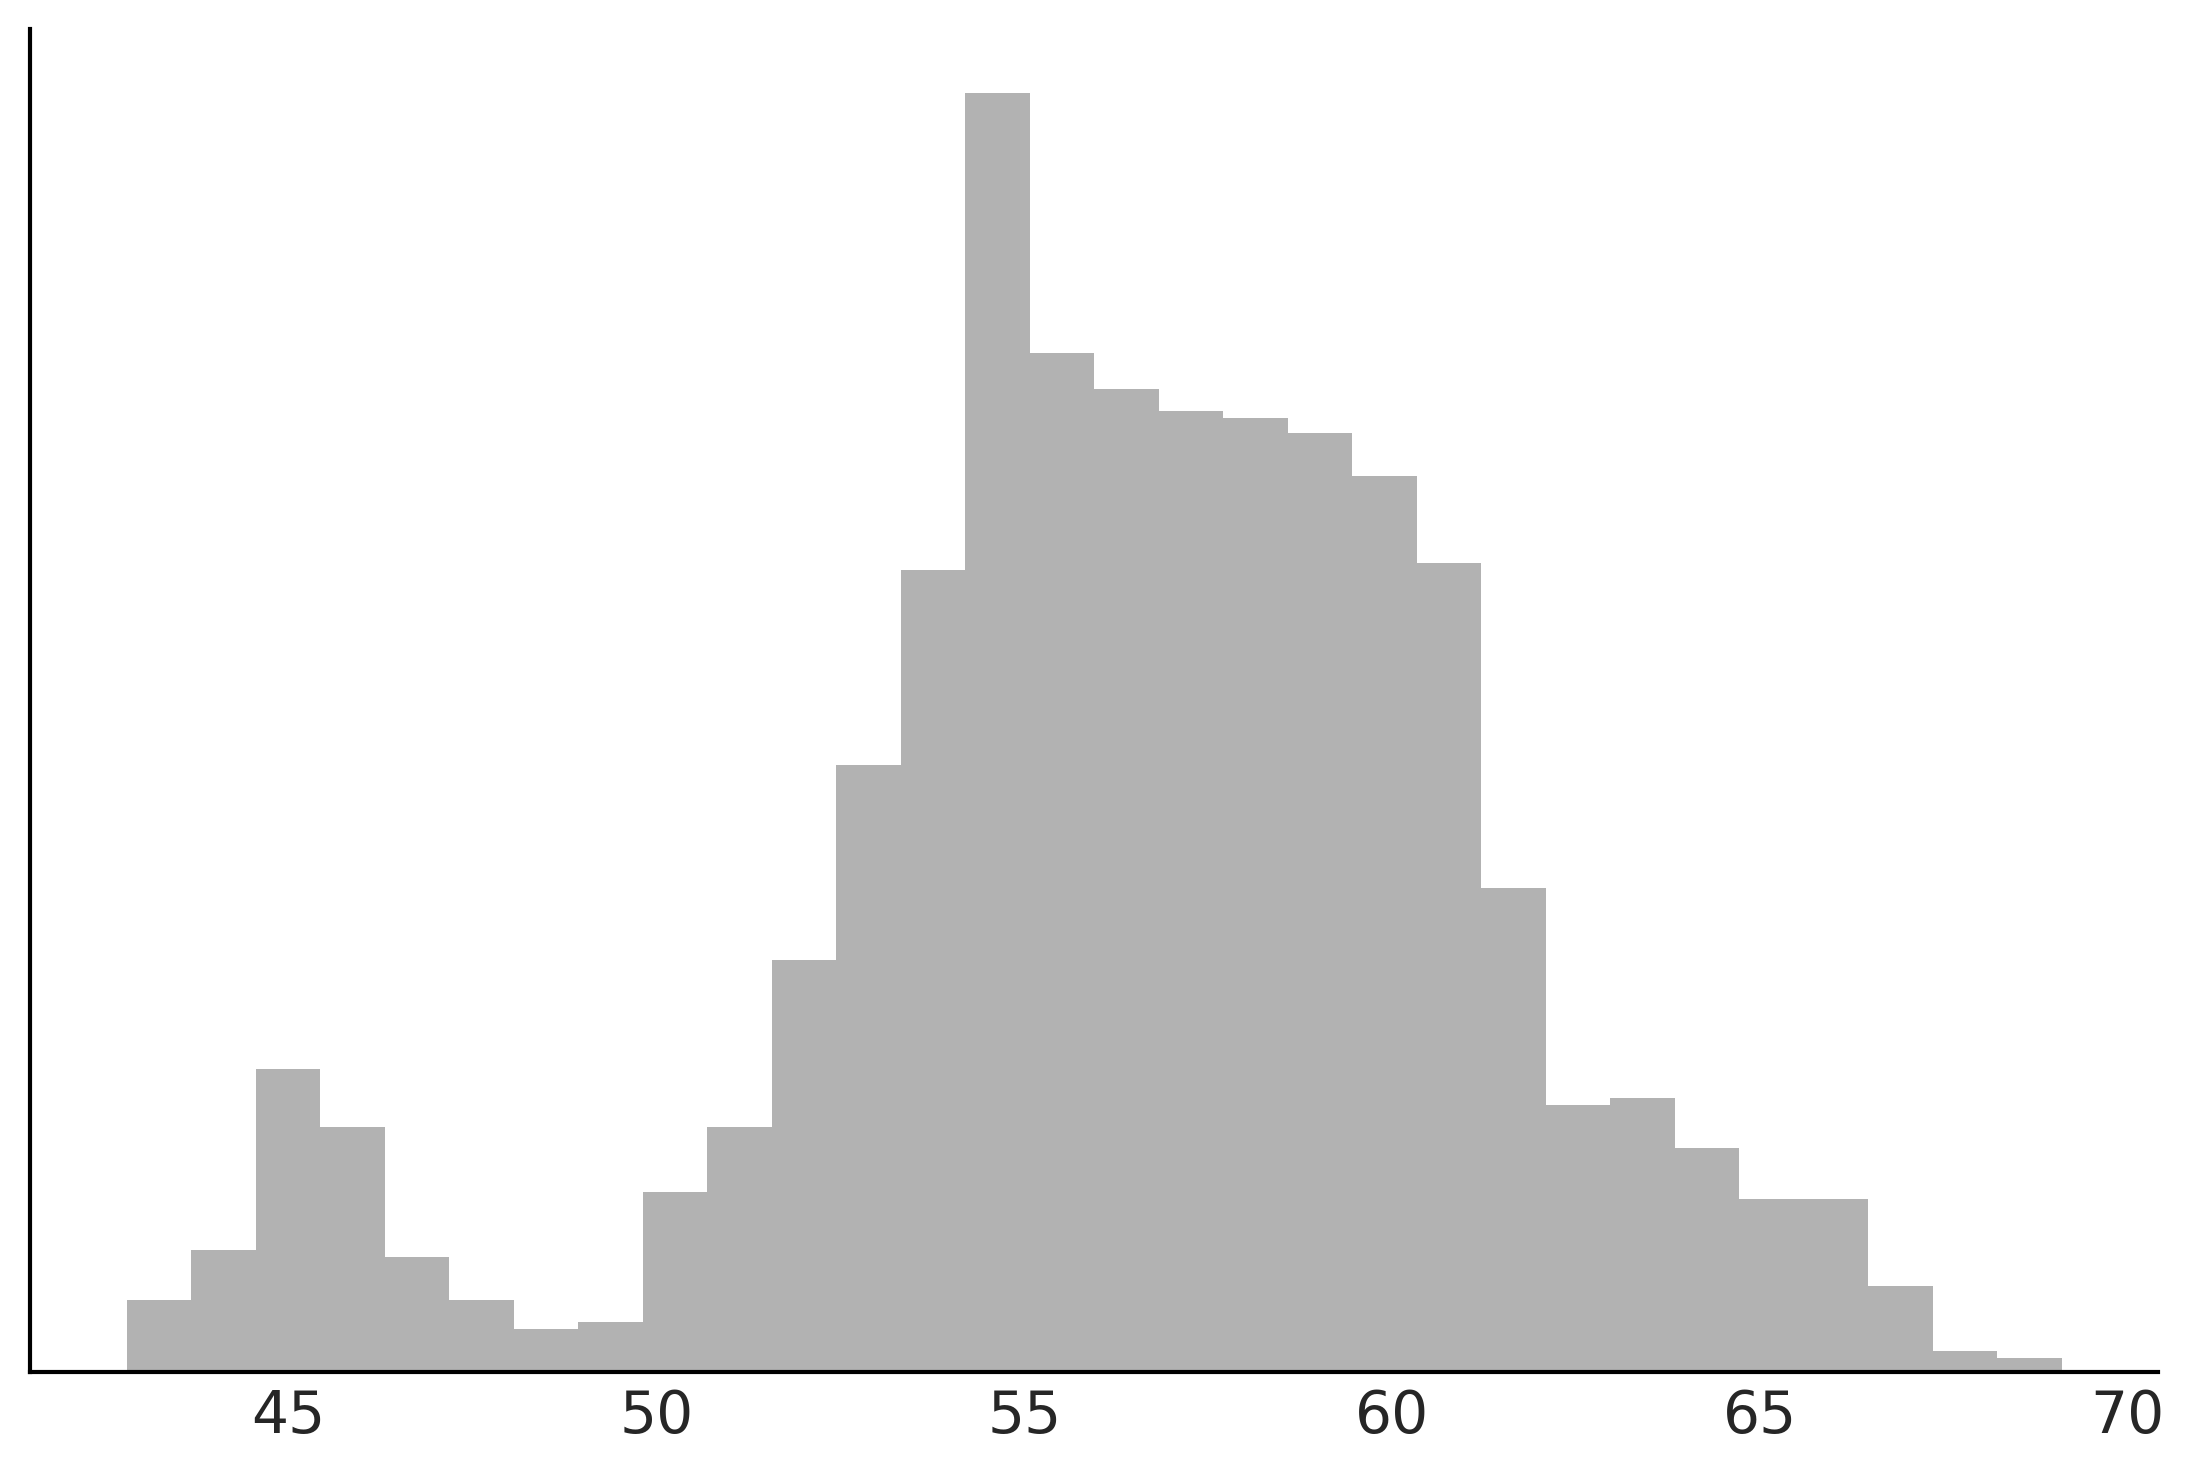

In [3]:
cs = pd.read_csv('data/chemical_shifts_theo_exp.csv')
cs_exp = cs['exp']
plt.hist(cs_exp, density=True, bins=30, alpha=0.3)
plt.yticks([])
plt.savefig("../fig/cs_exp_hist.png")

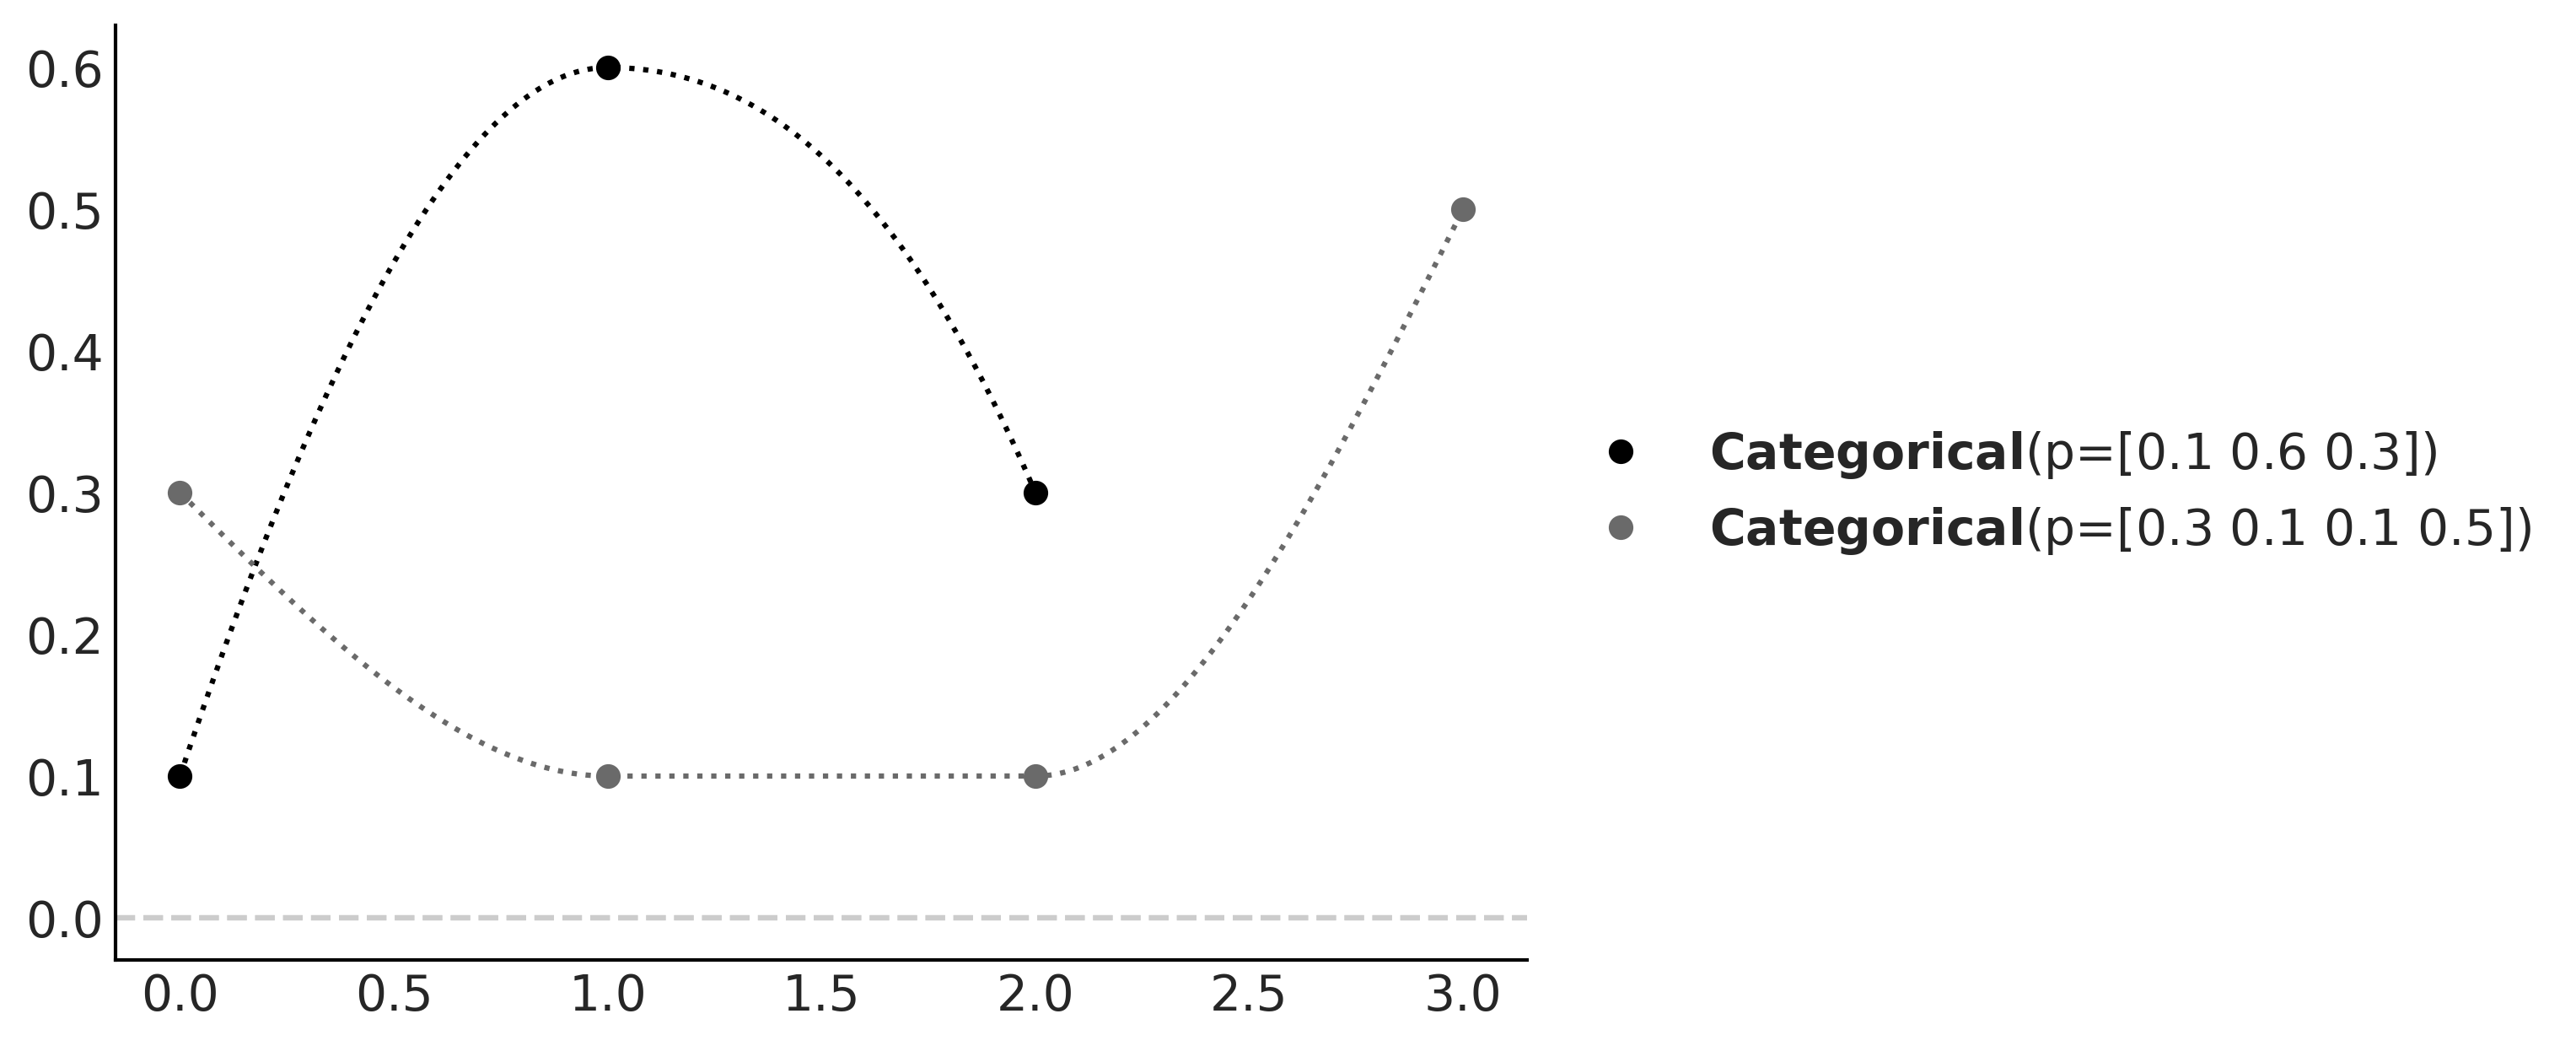

In [4]:
pz.Categorical([0.1, 0.6, 0.3]).plot_pdf()
pz.Categorical([0.3, 0.1, 0.1, 0.5]).plot_pdf()
plt.savefig("../fig/categorical_pmf.png")

In [5]:
# K = 2
# with pm.Model() as model_kg:
#    p = pm.Dirichlet('p', a=np.ones(K))
#    z = pm.Categorical('z', p=p, shape=len(cs_exp))
#    means = pm.Normal('means', mu=cs_exp.mean(), sigma=10, shape=K)
#    sd = pm.HalfNormal('sd', sigma=10)

#    y = pm.Normal('y', mu=means[z], sigma=sd, observed=cs_exp)
#    idata_kg = pm.sample()

In [6]:
K = 2
with pm.Model() as model_mg:
    p = pm.Dirichlet('p', a=np.ones(K))
    means = pm.Normal('means', mu=cs_exp.mean(), sigma=10, shape=K)
    sd = pm.HalfNormal('sd', sigma=5)
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=cs_exp)
    idata_mg = pm.sample(random_seed=123)


Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 9 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details


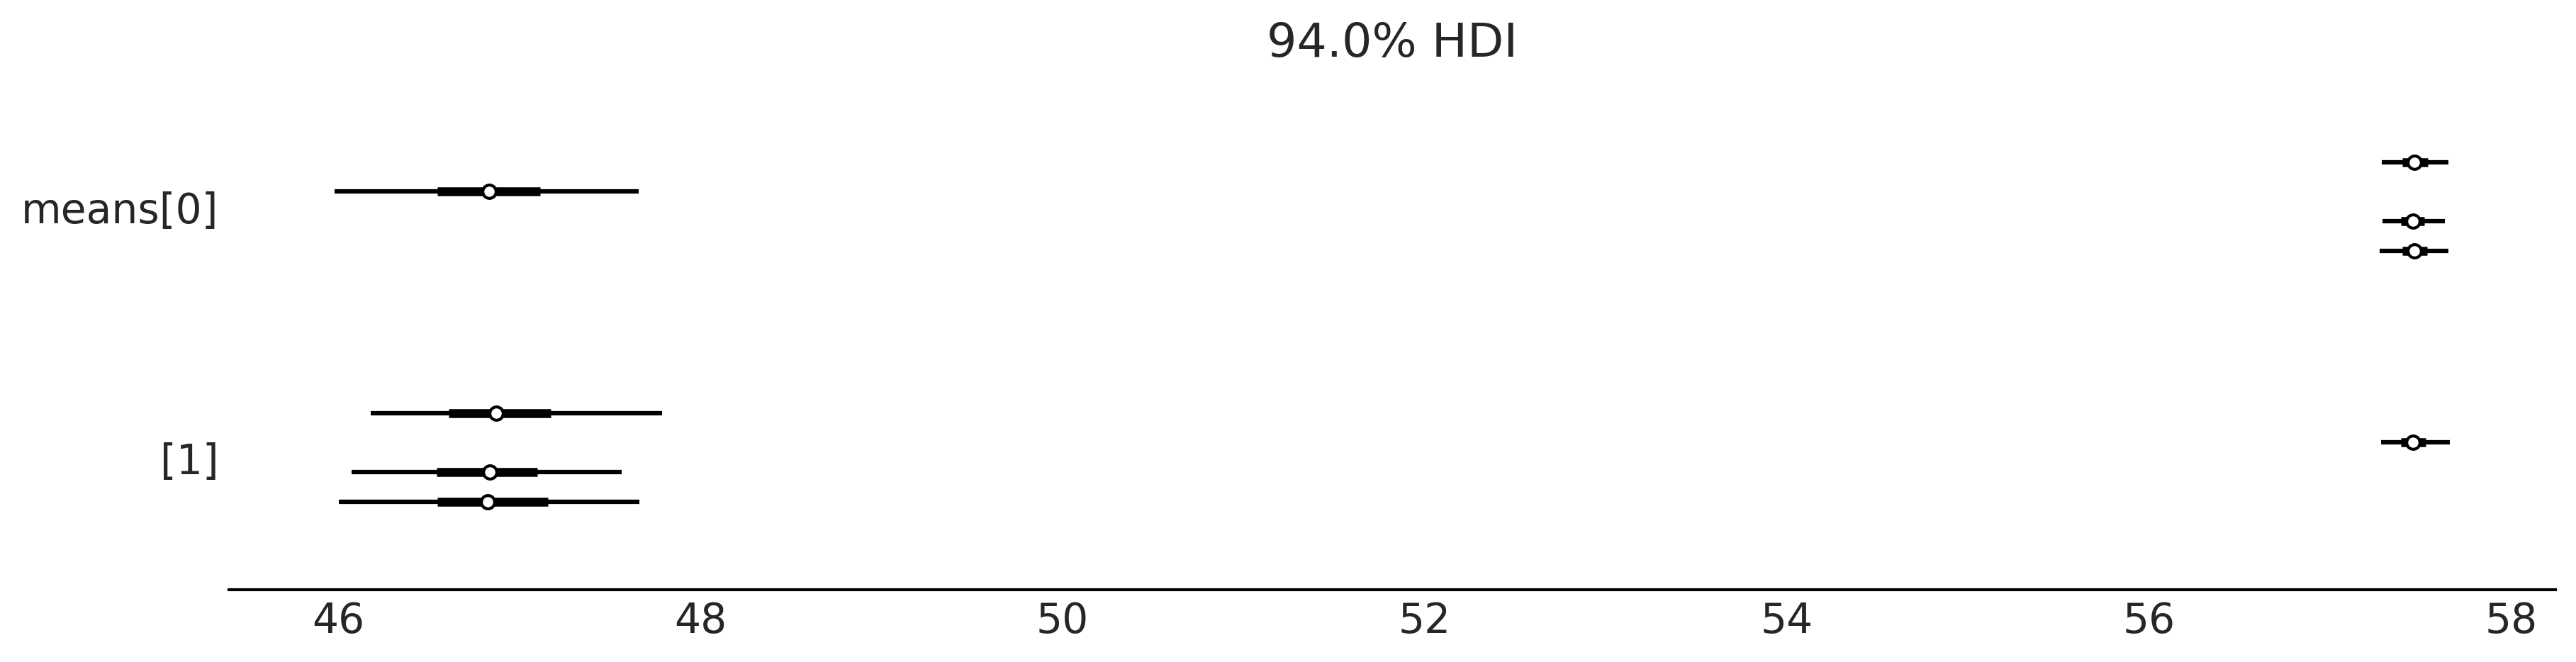

In [7]:
az.plot_forest(idata_mg, var_names="means", figsize=(12, 3))
plt.savefig("../fig/cs_means_forest_mg.png")

In [8]:
#az.summary(idata_mg, varnames)

In [9]:
K = 2
with pm.Model() as model_mgo:
    p = pm.Dirichlet('p', a=np.ones(K))
    means = pm.Normal('means', mu=cs_exp.mean(), sigma=10, shape=K,
                      transform=pm.distributions.transforms.univariate_ordered,
                      initval=np.array([cs_exp.mean()-1, cs_exp.mean()+1]))

    sd = pm.HalfNormal('sd', sigma=10)
    y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=cs_exp)
    idata_mgo = pm.sample(random_seed=123)

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [p, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 12 seconds.


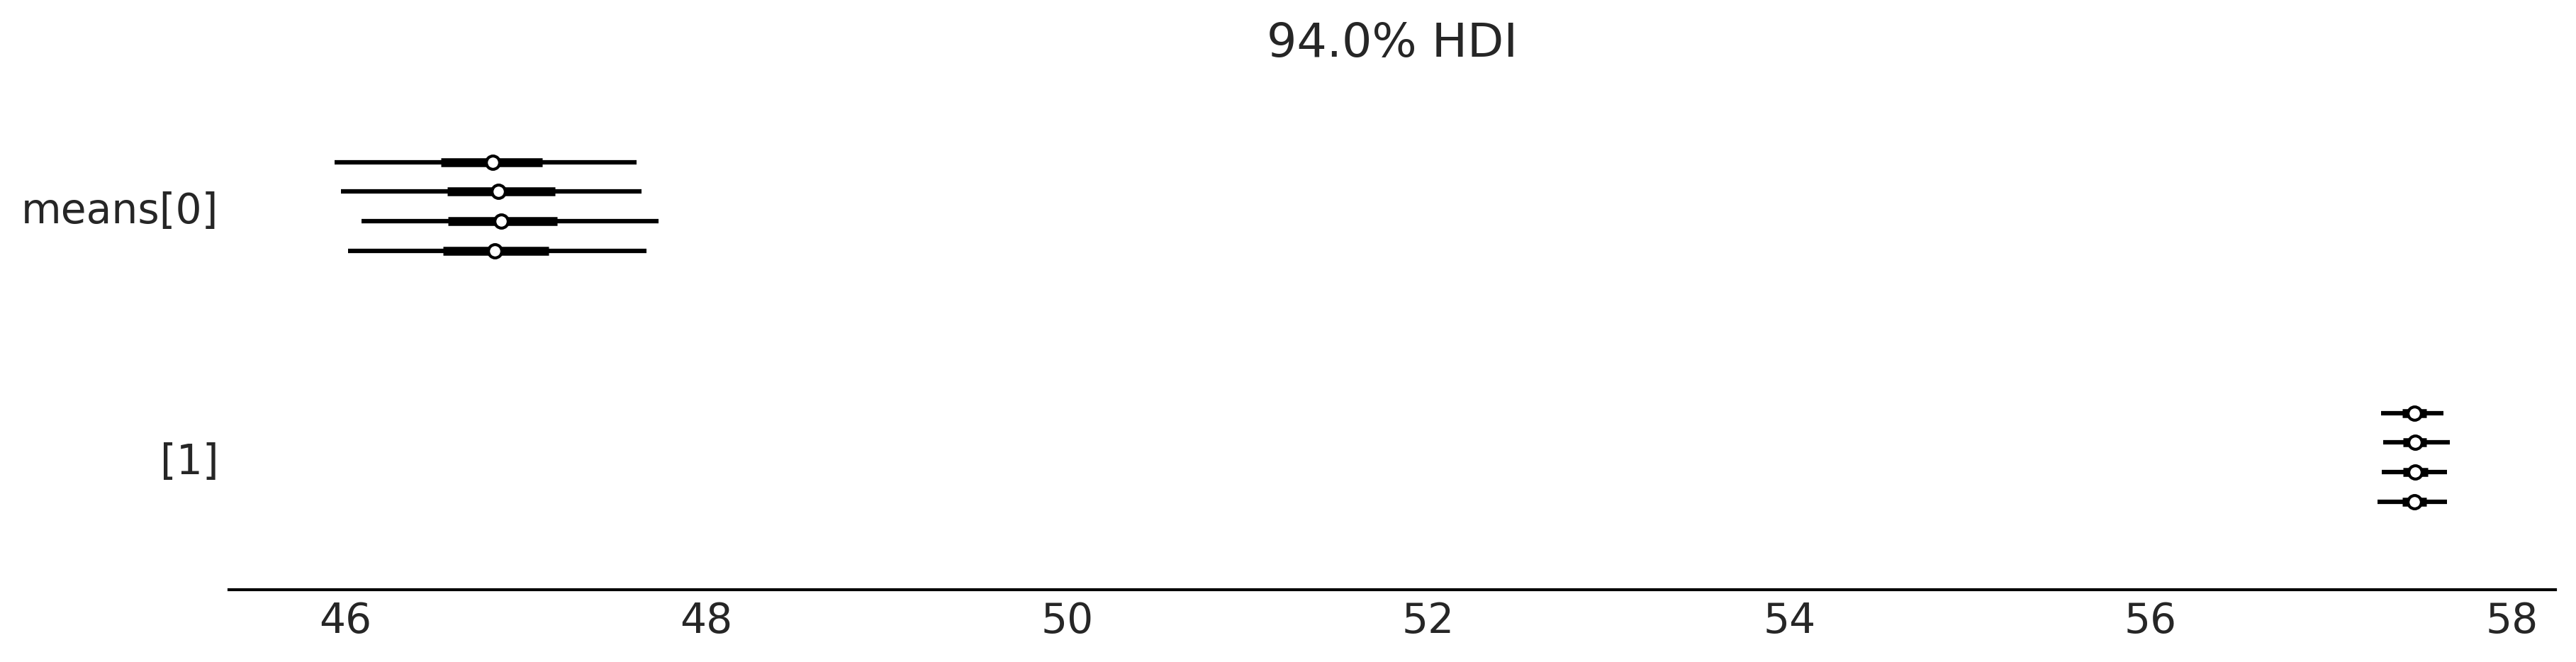

In [10]:
az.plot_forest(idata_mgo, var_names="means", figsize=(12, 3))
plt.savefig("../fig/cs_means_forest_mgo.png")

In [25]:
Ks = [2, 3, 4, 5]

models = []
idatas = []
for k in Ks:
    with pm.Model() as model:
        p = pm.Dirichlet('p', a=np.ones(k))
        means = pm.Normal('means',
                          mu=np.linspace(cs_exp.min(), cs_exp.max(), k),
                          sigma=cs_exp.var() / k, shape=k,
                          transform=pm.distributions.transforms.univariate_ordered,
                          )
        sd = pm.HalfNormal('sd', sigma=5)
        y = pm.NormalMixture('y', w=p, mu=means, sigma=sd, observed=cs_exp)
        idata = pm.sample(random_seed=123,
                          idata_kwargs={"log_likelihood":True}
                         )
        idatas.append(idata)
        models.append(model)

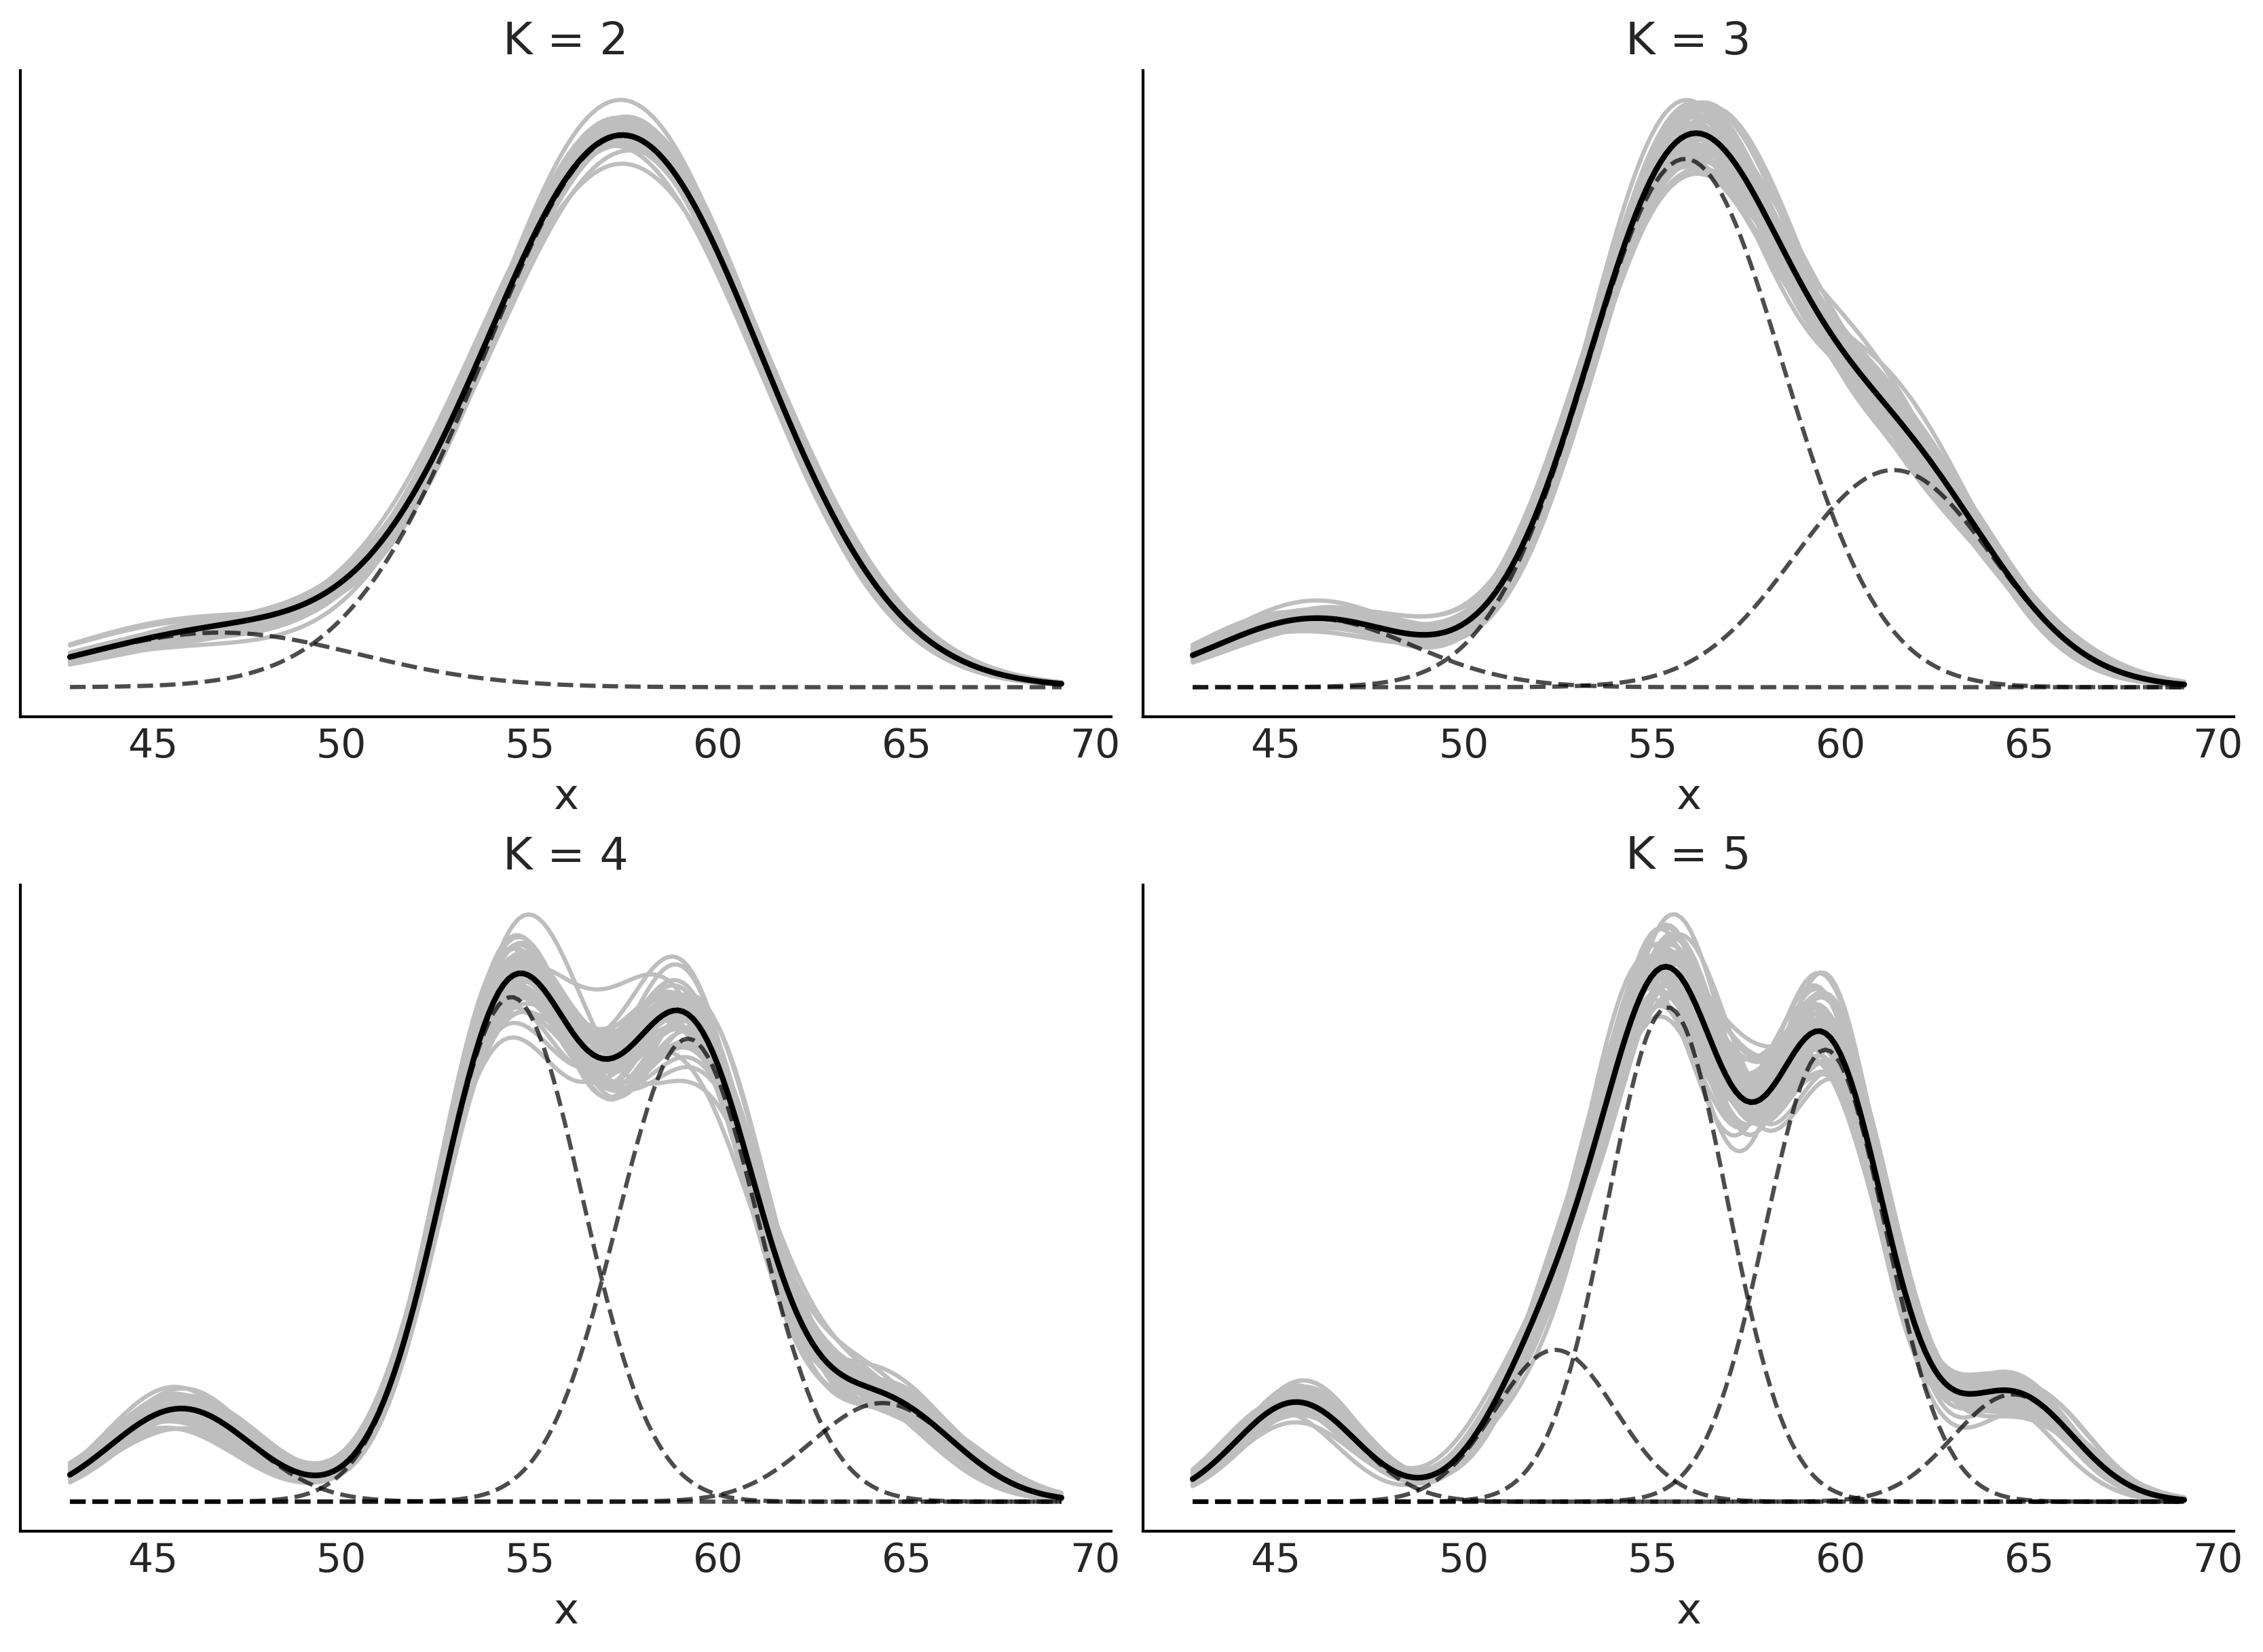

In [27]:
_, ax = plt.subplots(2, 2, figsize=(11, 8))
 
ax = np.ravel(ax)
x = np.linspace(cs_exp.min(), cs_exp.max(), 200)
for idx, idata_x in enumerate(idatas):
    posterior_x = idata_x.posterior.stack(samples=("chain", "draw"))
    x_ = np.array([x] * Ks[idx]).T

    for i_ in np.random.randint(0, posterior_x.samples.size, size=50):
        dist = pz.Normal(posterior_x['means'][:,i_], posterior_x['sd'][i_])
        ax[idx].plot(x, np.sum(dist.pdf(x_) *  posterior_x['p'][:,i_].values, 1), 'C2')
 
    p_y = posterior_x['p'].mean("samples")
    dist = pz.Normal(posterior_x['means'].mean("samples"), posterior_x['sd'].mean())
    ax[idx].plot(x, np.sum(dist.pdf(x_) * p_y.values, 1), 'C0', lw=2)
    ax[idx].plot(x, dist.pdf(x_) * p_y.values, 'k--', alpha=0.7)
         
    ax[idx].set_title('K = {}'.format(Ks[idx]))
    ax[idx].set_yticks([])
    ax[idx].set_xlabel('x')
plt.savefig("../fig/mixture_models_K.png")

Sampling: [y]


Sampling: [y]


Sampling: [y]


Sampling: [y]


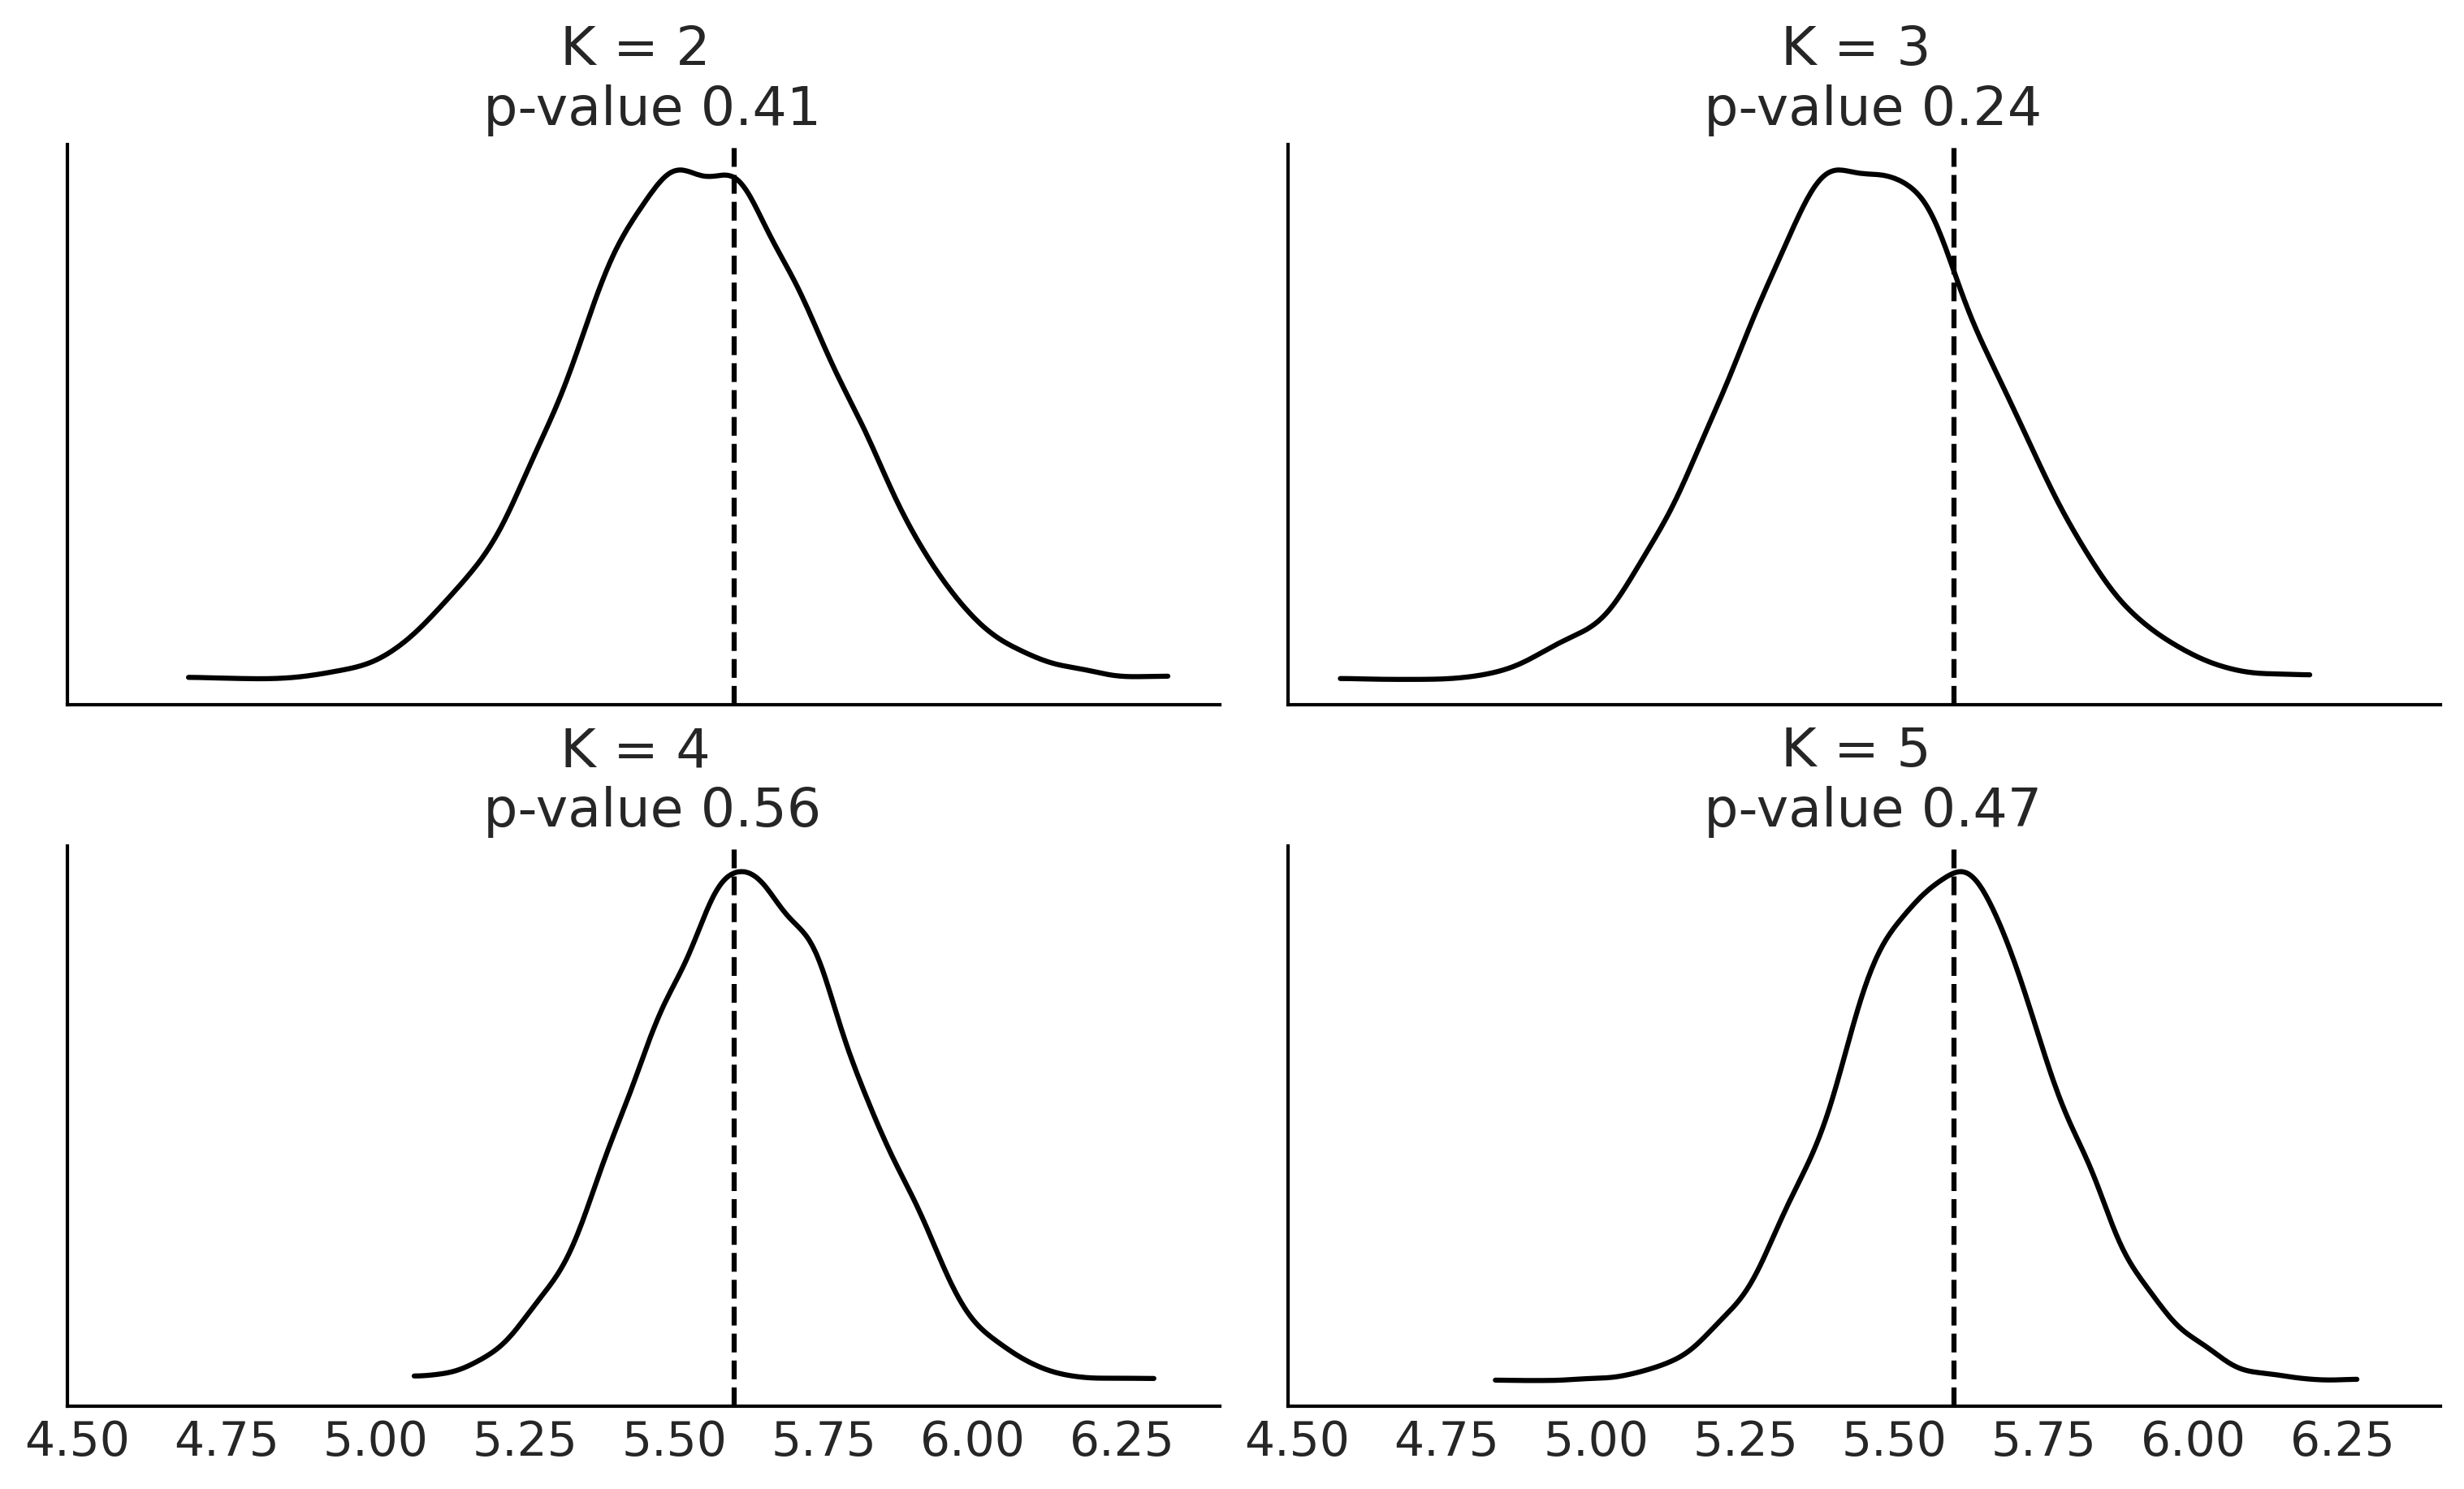

In [13]:
ppc_mm = [pm.sample_posterior_predictive(idatas[i], models[i]) for i in range(4)]

fig, ax = plt.subplots(2, 2, figsize=(10, 6), sharex=True)
ax = np.ravel(ax)
def iqr(x, a=0):
    return np.subtract(*np.percentile(x, [75, 25], axis=a))
    
T_obs = iqr(cs_exp)
for idx, d_sim in enumerate(ppc_mm):
    d_sim = d_sim.posterior_predictive["y"]
    T_sim = iqr(d_sim, 1)
    p_value = np.mean(T_sim >= T_obs)
    az.plot_kde(T_sim, ax=ax[idx])
    ax[idx].axvline(T_obs, 0, 1, color='k', ls='--')
    ax[idx].set_title(f'K = {Ks[idx]} \n p-value {p_value:.2f}')
    ax[idx].set_yticks([])


plt.savefig("../fig/mixture_models_ppc.png")

In [14]:
comp = az.compare(dict(zip([str(K) for K in Ks], idatas)))
comp

,rank,elpd_loo,p_loo,elpd_diff,weight,se,dse,warning,scale
5,0,-5129.223680,9.953179,0.000000,1.000000e+00,30.702435,0.000000,False,log
4,1,-5139.567185,7.599073,10.343505,0.000000e+00,31.262451,4.218300,False,log
3,2,-5178.378883,5.874274,49.155203,0.000000e+00,31.866948,8.846294,False,log
2,3,-5215.993747,3.335475,86.770067,1.826095e-11,33.498902,11.956837,False,log


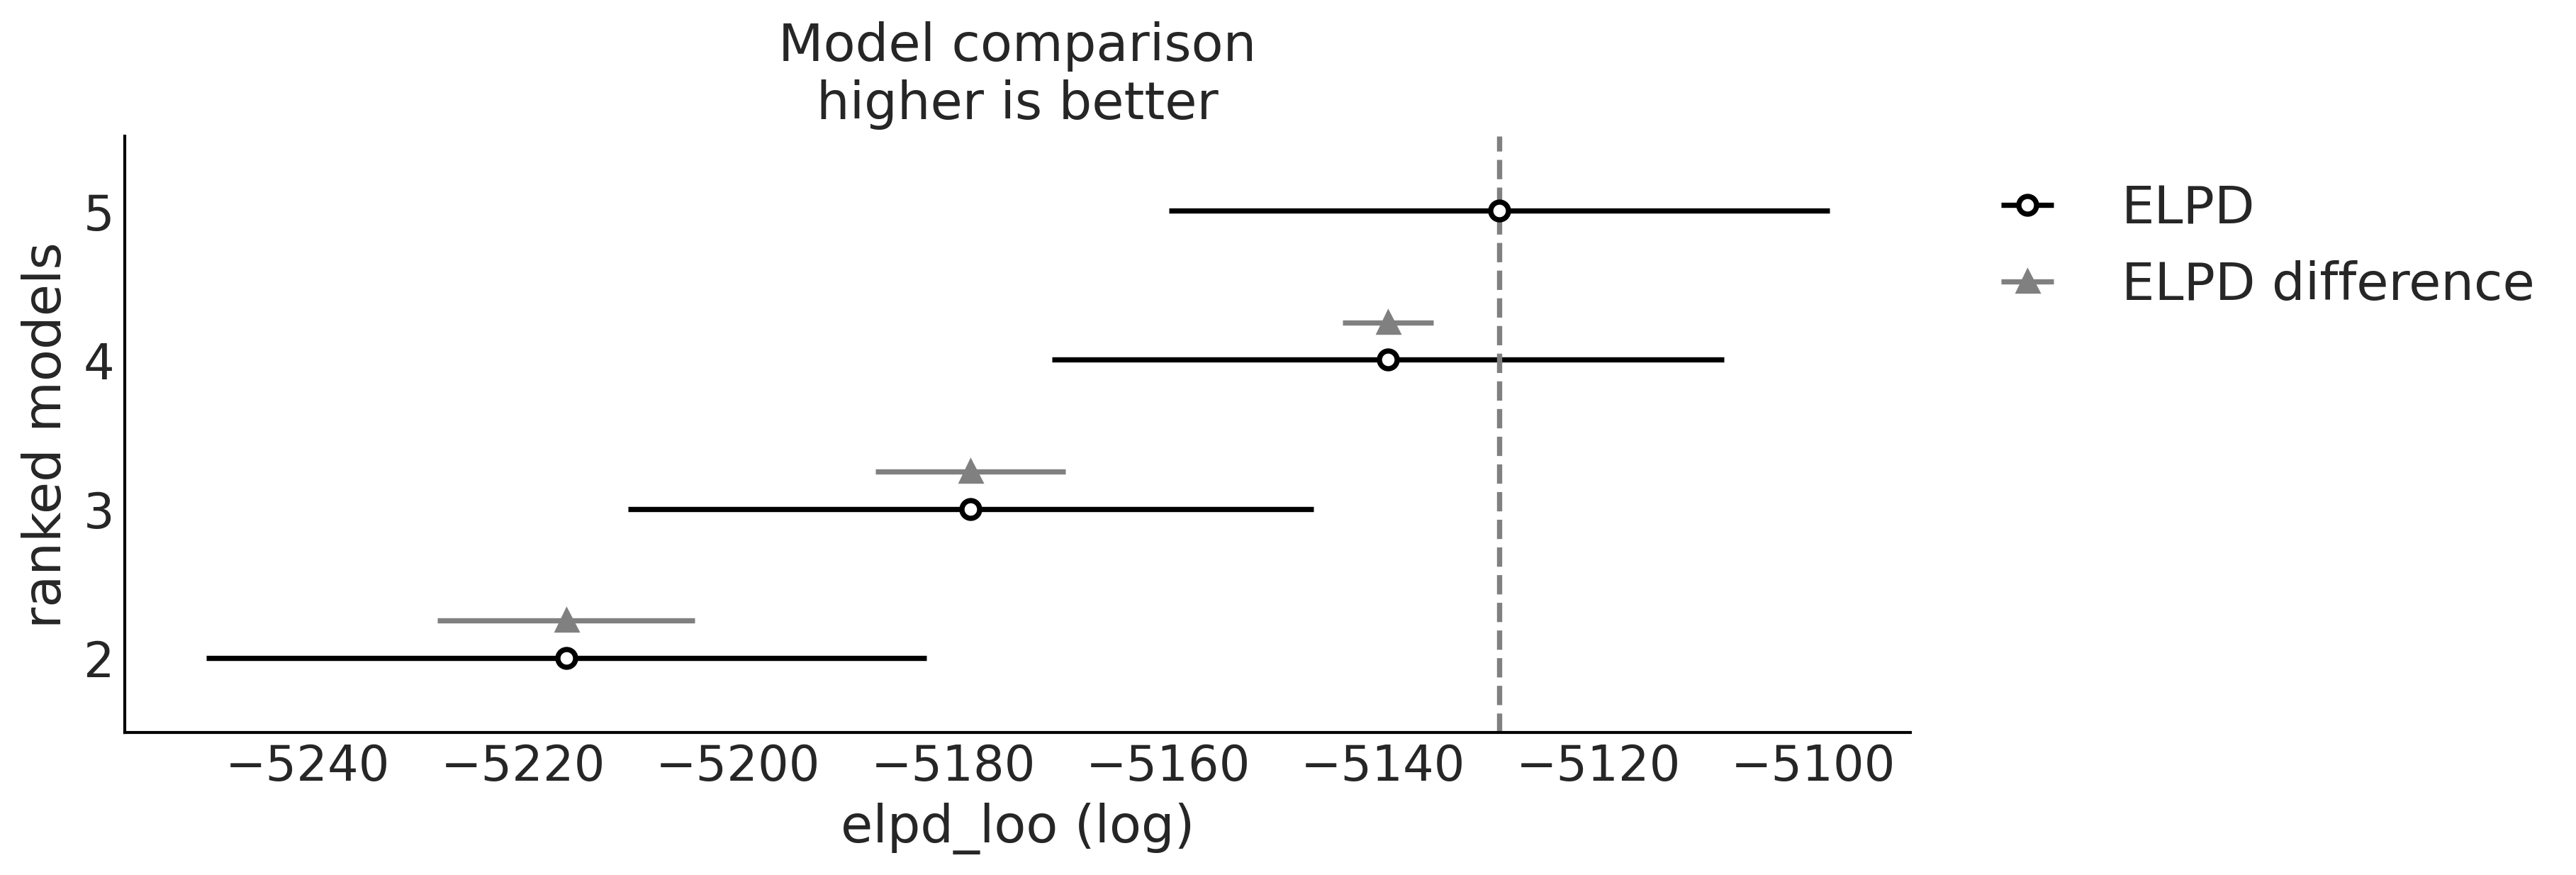

In [15]:
az.plot_compare(comp, figsize=(12, 4))
plt.savefig('../fig/mixture_models_loo.png')

## Non-finite mixture models

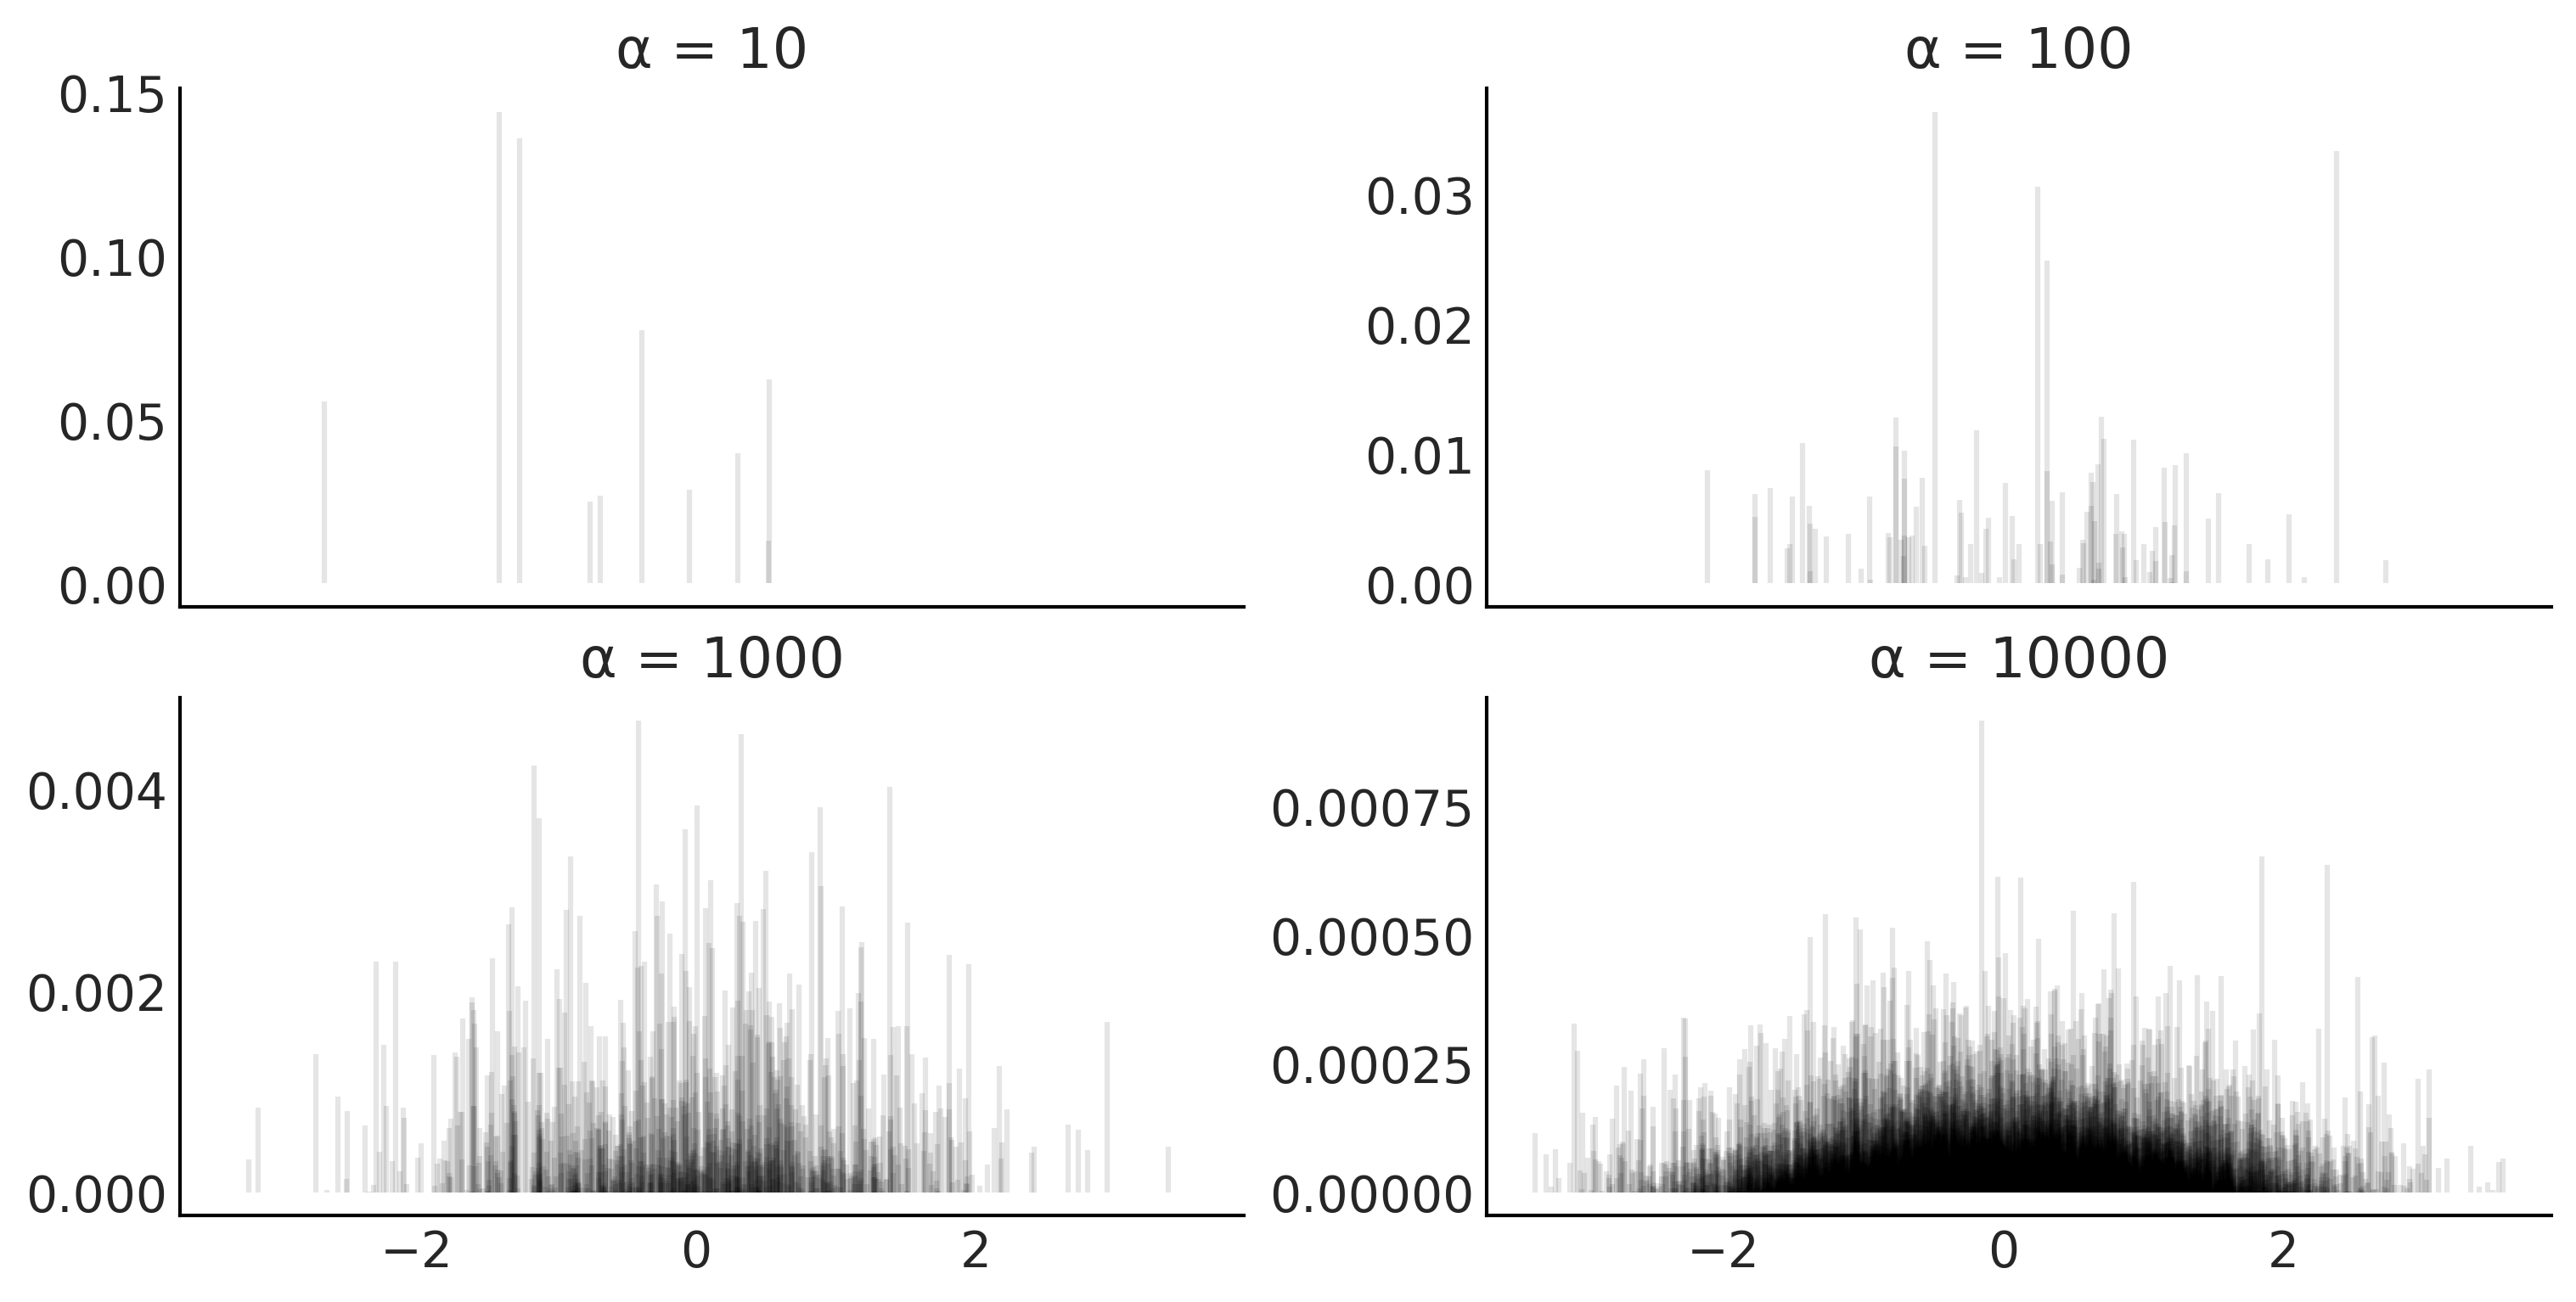

In [16]:
def stick_breaking_truncated(α, H, K):
    """
    Truncated stick-breaking process view of a DP
    
    Parameters
    ----------
    α : float
        concentration parameter
    H : Preliz distribution
        Base distribution
    K : int
        number of components
    
    Returns
    -------
    locs : array
        locations
    w : array
        probabilities
    """
    βs = pz.Beta(1, α).rvs(K)
    w = np.empty(K)
    w = βs * np.concatenate(([1.], np.cumprod(1 - βs[:-1])))
    locs = H.rvs(size=K)
    return locs, w

# Parameters DP
H = pz.Normal(0, 1)
alphas = [10, 100, 1000, 10000]
Ks = alphas * 10

# plot
_, ax = plt.subplots(2, 2, sharex=True, figsize=(10, 5))
ax = np.ravel(ax)
for idx, (α, K) in enumerate(zip(alphas, Ks)):
    locs, w = stick_breaking_truncated(α, H, K)
    ax[idx].vlines(locs, 0, w, color='C0', alpha=0.1)
    ax[idx].set_title('α = {}'.format(α))

plt.savefig('../fig/stick_breaking.png')

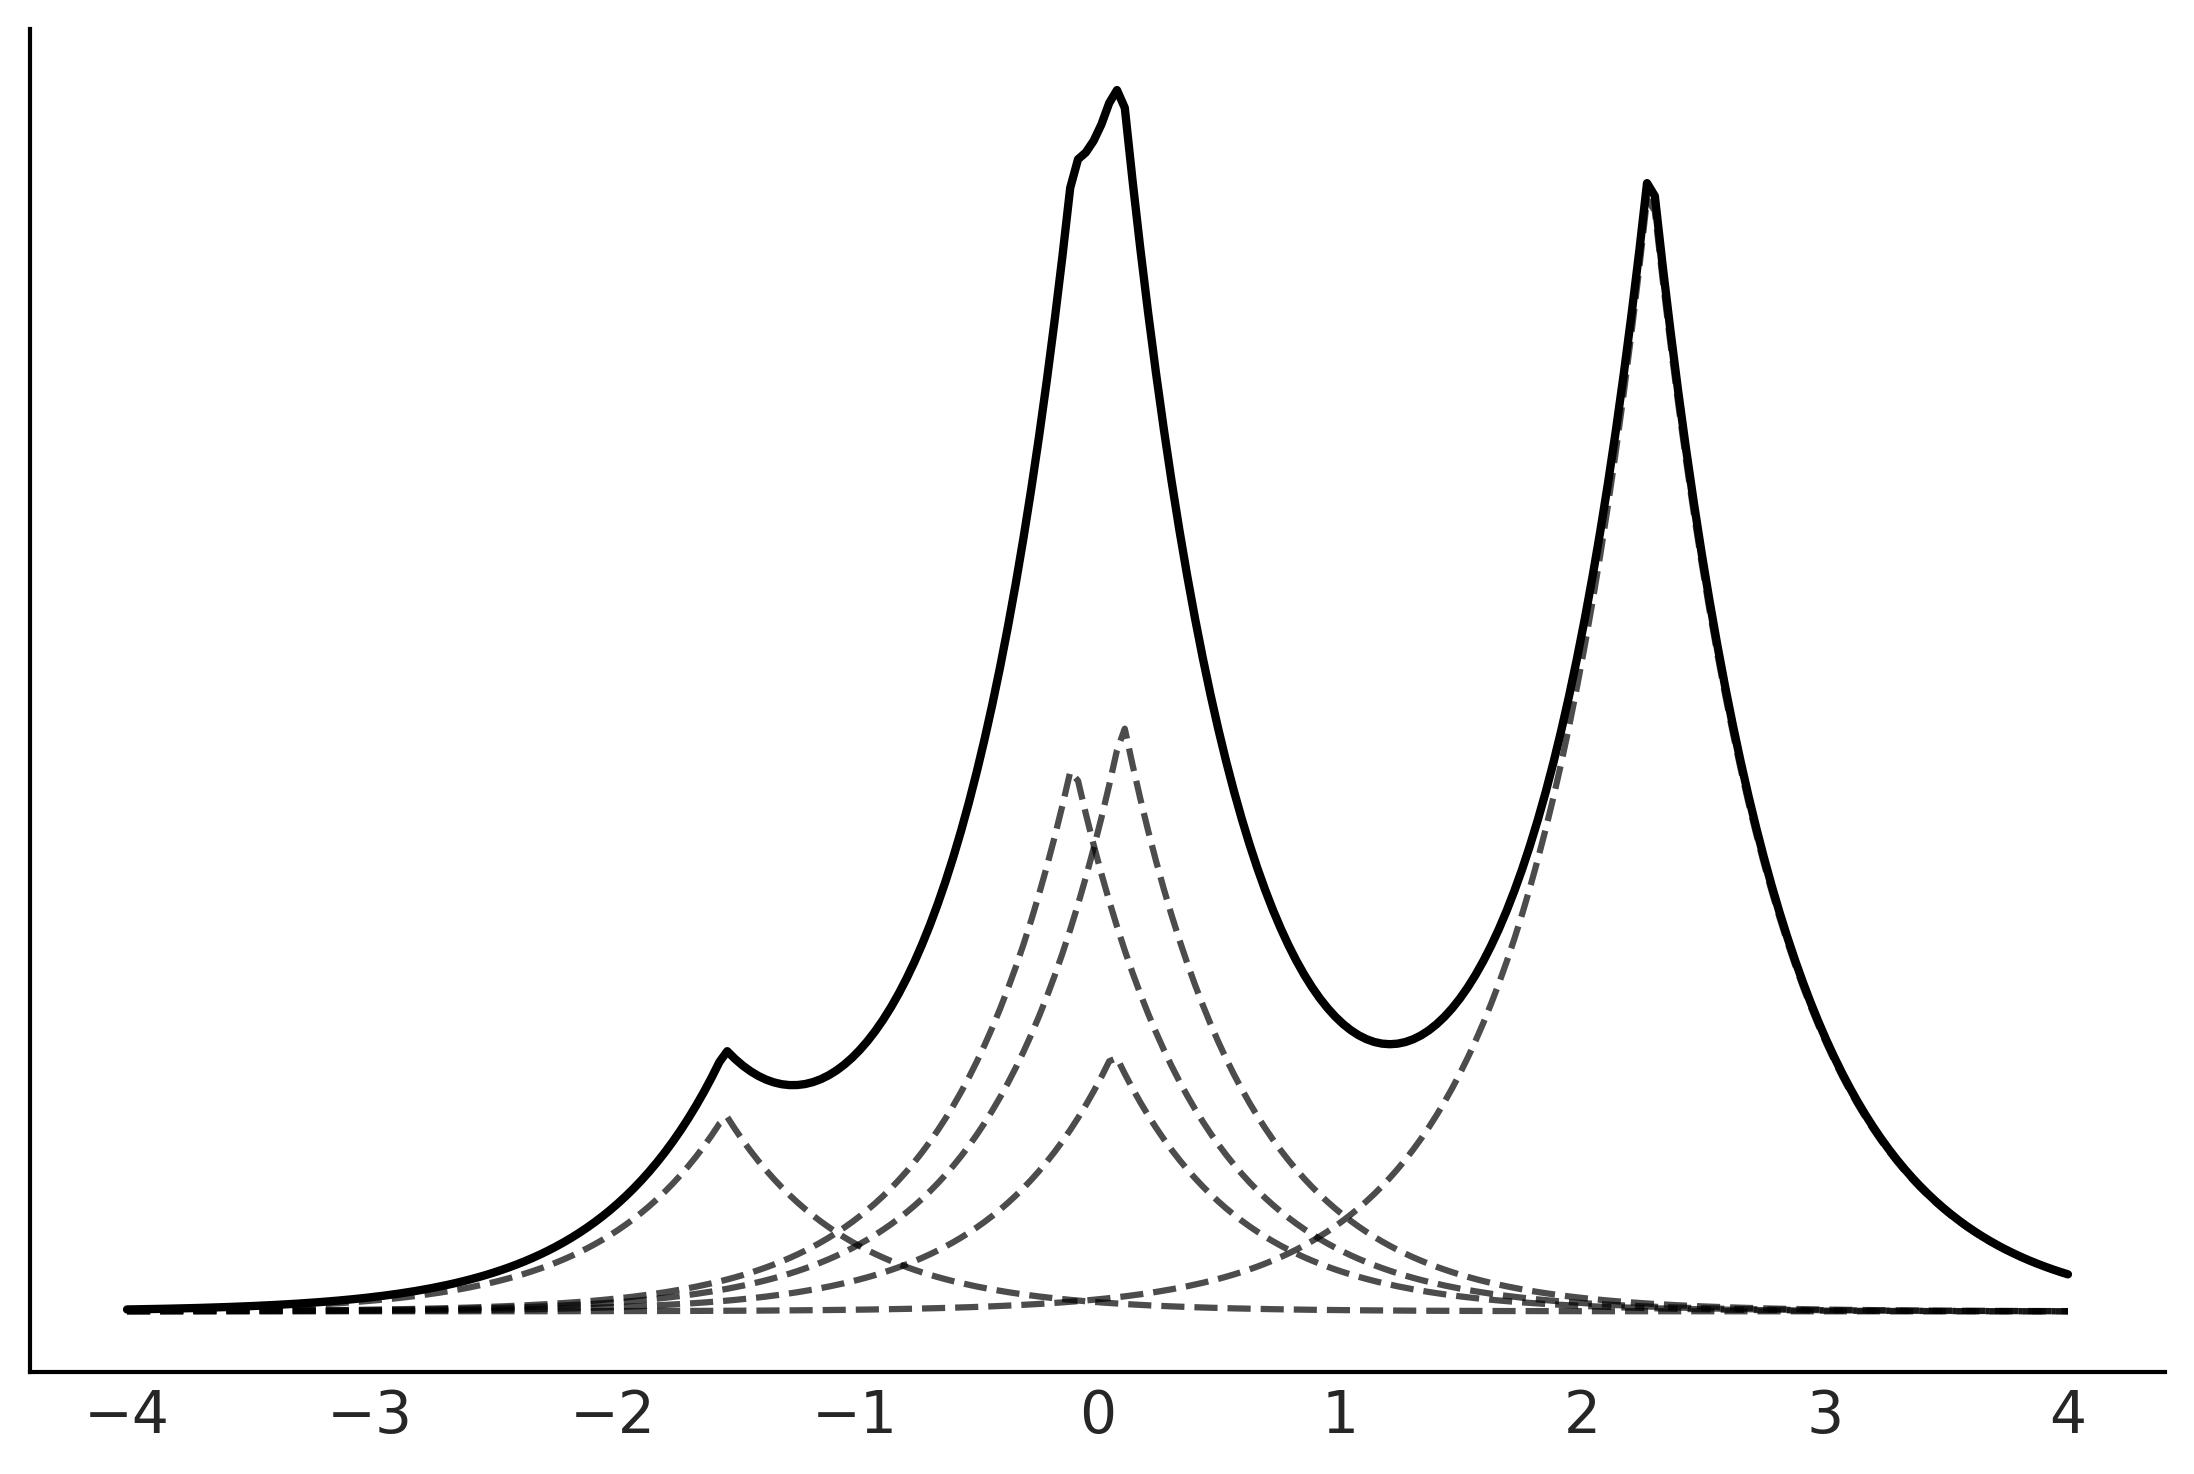

In [17]:
α = 10
H = pz.Normal(0, 1)
K = 5

x = np.linspace(-4, 4, 250)
x_ = np.array([x] * K).T
locs, w = stick_breaking_truncated(α, H, K)

dist = pz.Laplace(locs, 0.5)
plt.plot(x, np.sum(dist.pdf(x_) * w, 1), 'C0', lw=2)
plt.plot(x, dist.pdf(x_) * w, 'k--', alpha=0.7)
plt.yticks([])

plt.savefig('../fig/Laplace_DP_mixture.png')

In [18]:
K = 10

def stick_breaking(α, K):
    β = pm.Beta('β', 1., α, shape=K)
    w = β * pt.concatenate([[1.], pt.extra_ops.cumprod(1. - β)[:-1]]) + 1E-6
    return w/w.sum()

In [19]:
with pm.Model() as model_DP:
    α = pm.Gamma('α', 2, 1)
    w = pm.Deterministic('w', stick_breaking(α, K)) 
    means = pm.Normal('means',
                      mu=np.linspace(cs_exp.min(), cs_exp.max(), K),
                      sigma=5, shape=K,
                      transform=pm.distributions.transforms.univariate_ordered,
                     )
    
    sd = pm.HalfNormal('sd', sigma=10, shape=K)
    obs = pm.NormalMixture('obs', w, means, sigma=sd, observed=cs_exp.values)
    idata = pm.sample()

Auto-assigning NUTS sampler...
Initializing NUTS using jitter+adapt_diag...
Multiprocess sampling (4 chains in 4 jobs)
NUTS: [α, β, means, sd]


Sampling 4 chains for 1_000 tune and 1_000 draw iterations (4_000 + 4_000 draws total) took 367 seconds.
The rhat statistic is larger than 1.01 for some parameters. This indicates problems during sampling. See https://arxiv.org/abs/1903.08008 for details
The effective sample size per chain is smaller than 100 for some parameters.  A higher number is needed for reliable rhat and ess computation. See https://arxiv.org/abs/1903.08008 for details
There were 1 divergences after tuning. Increase `target_accept` or reparameterize.


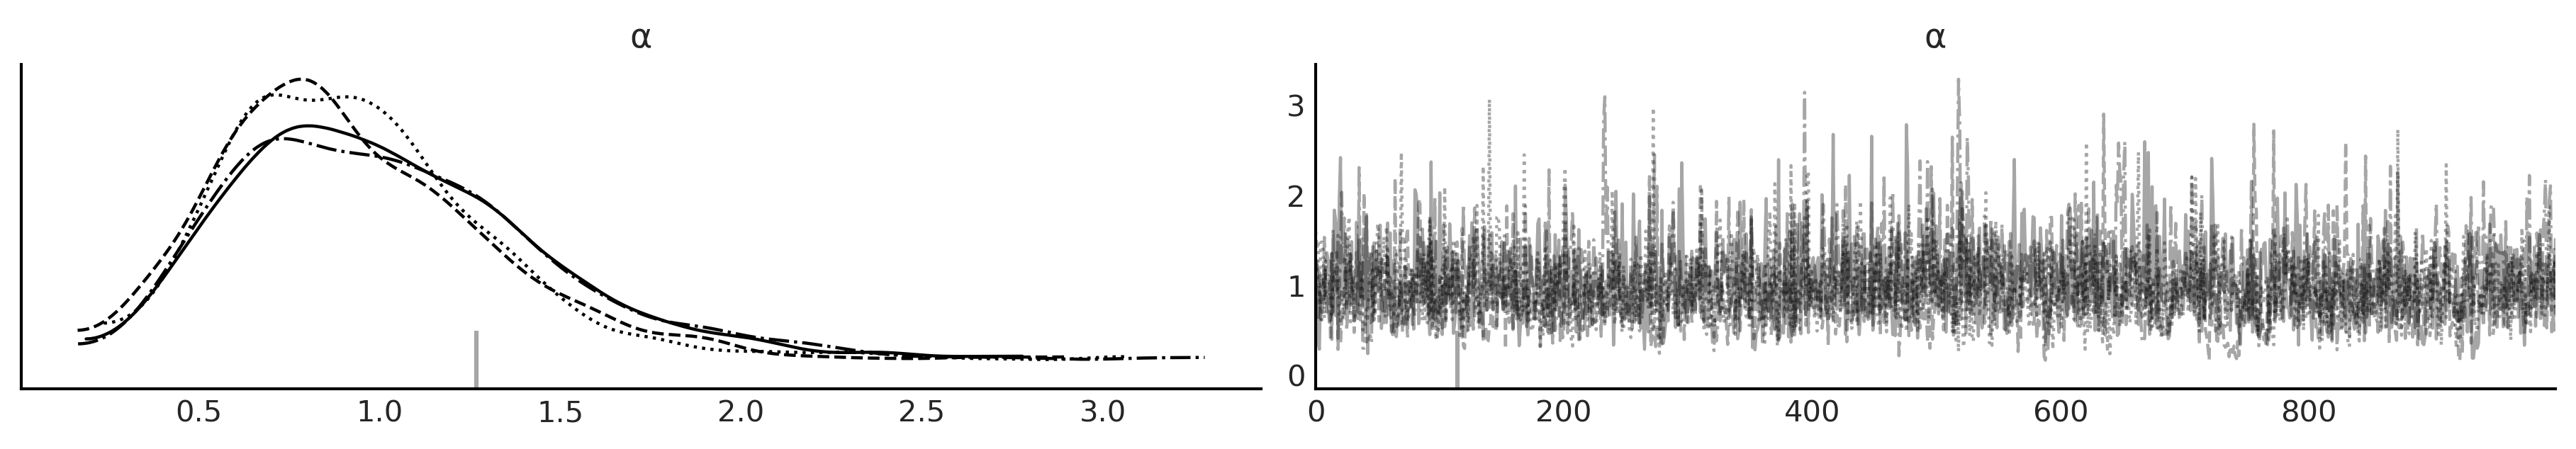

In [20]:
az.plot_trace(idata, var_names=['α']);
plt.savefig('../fig/trace_DP_mixture.png')

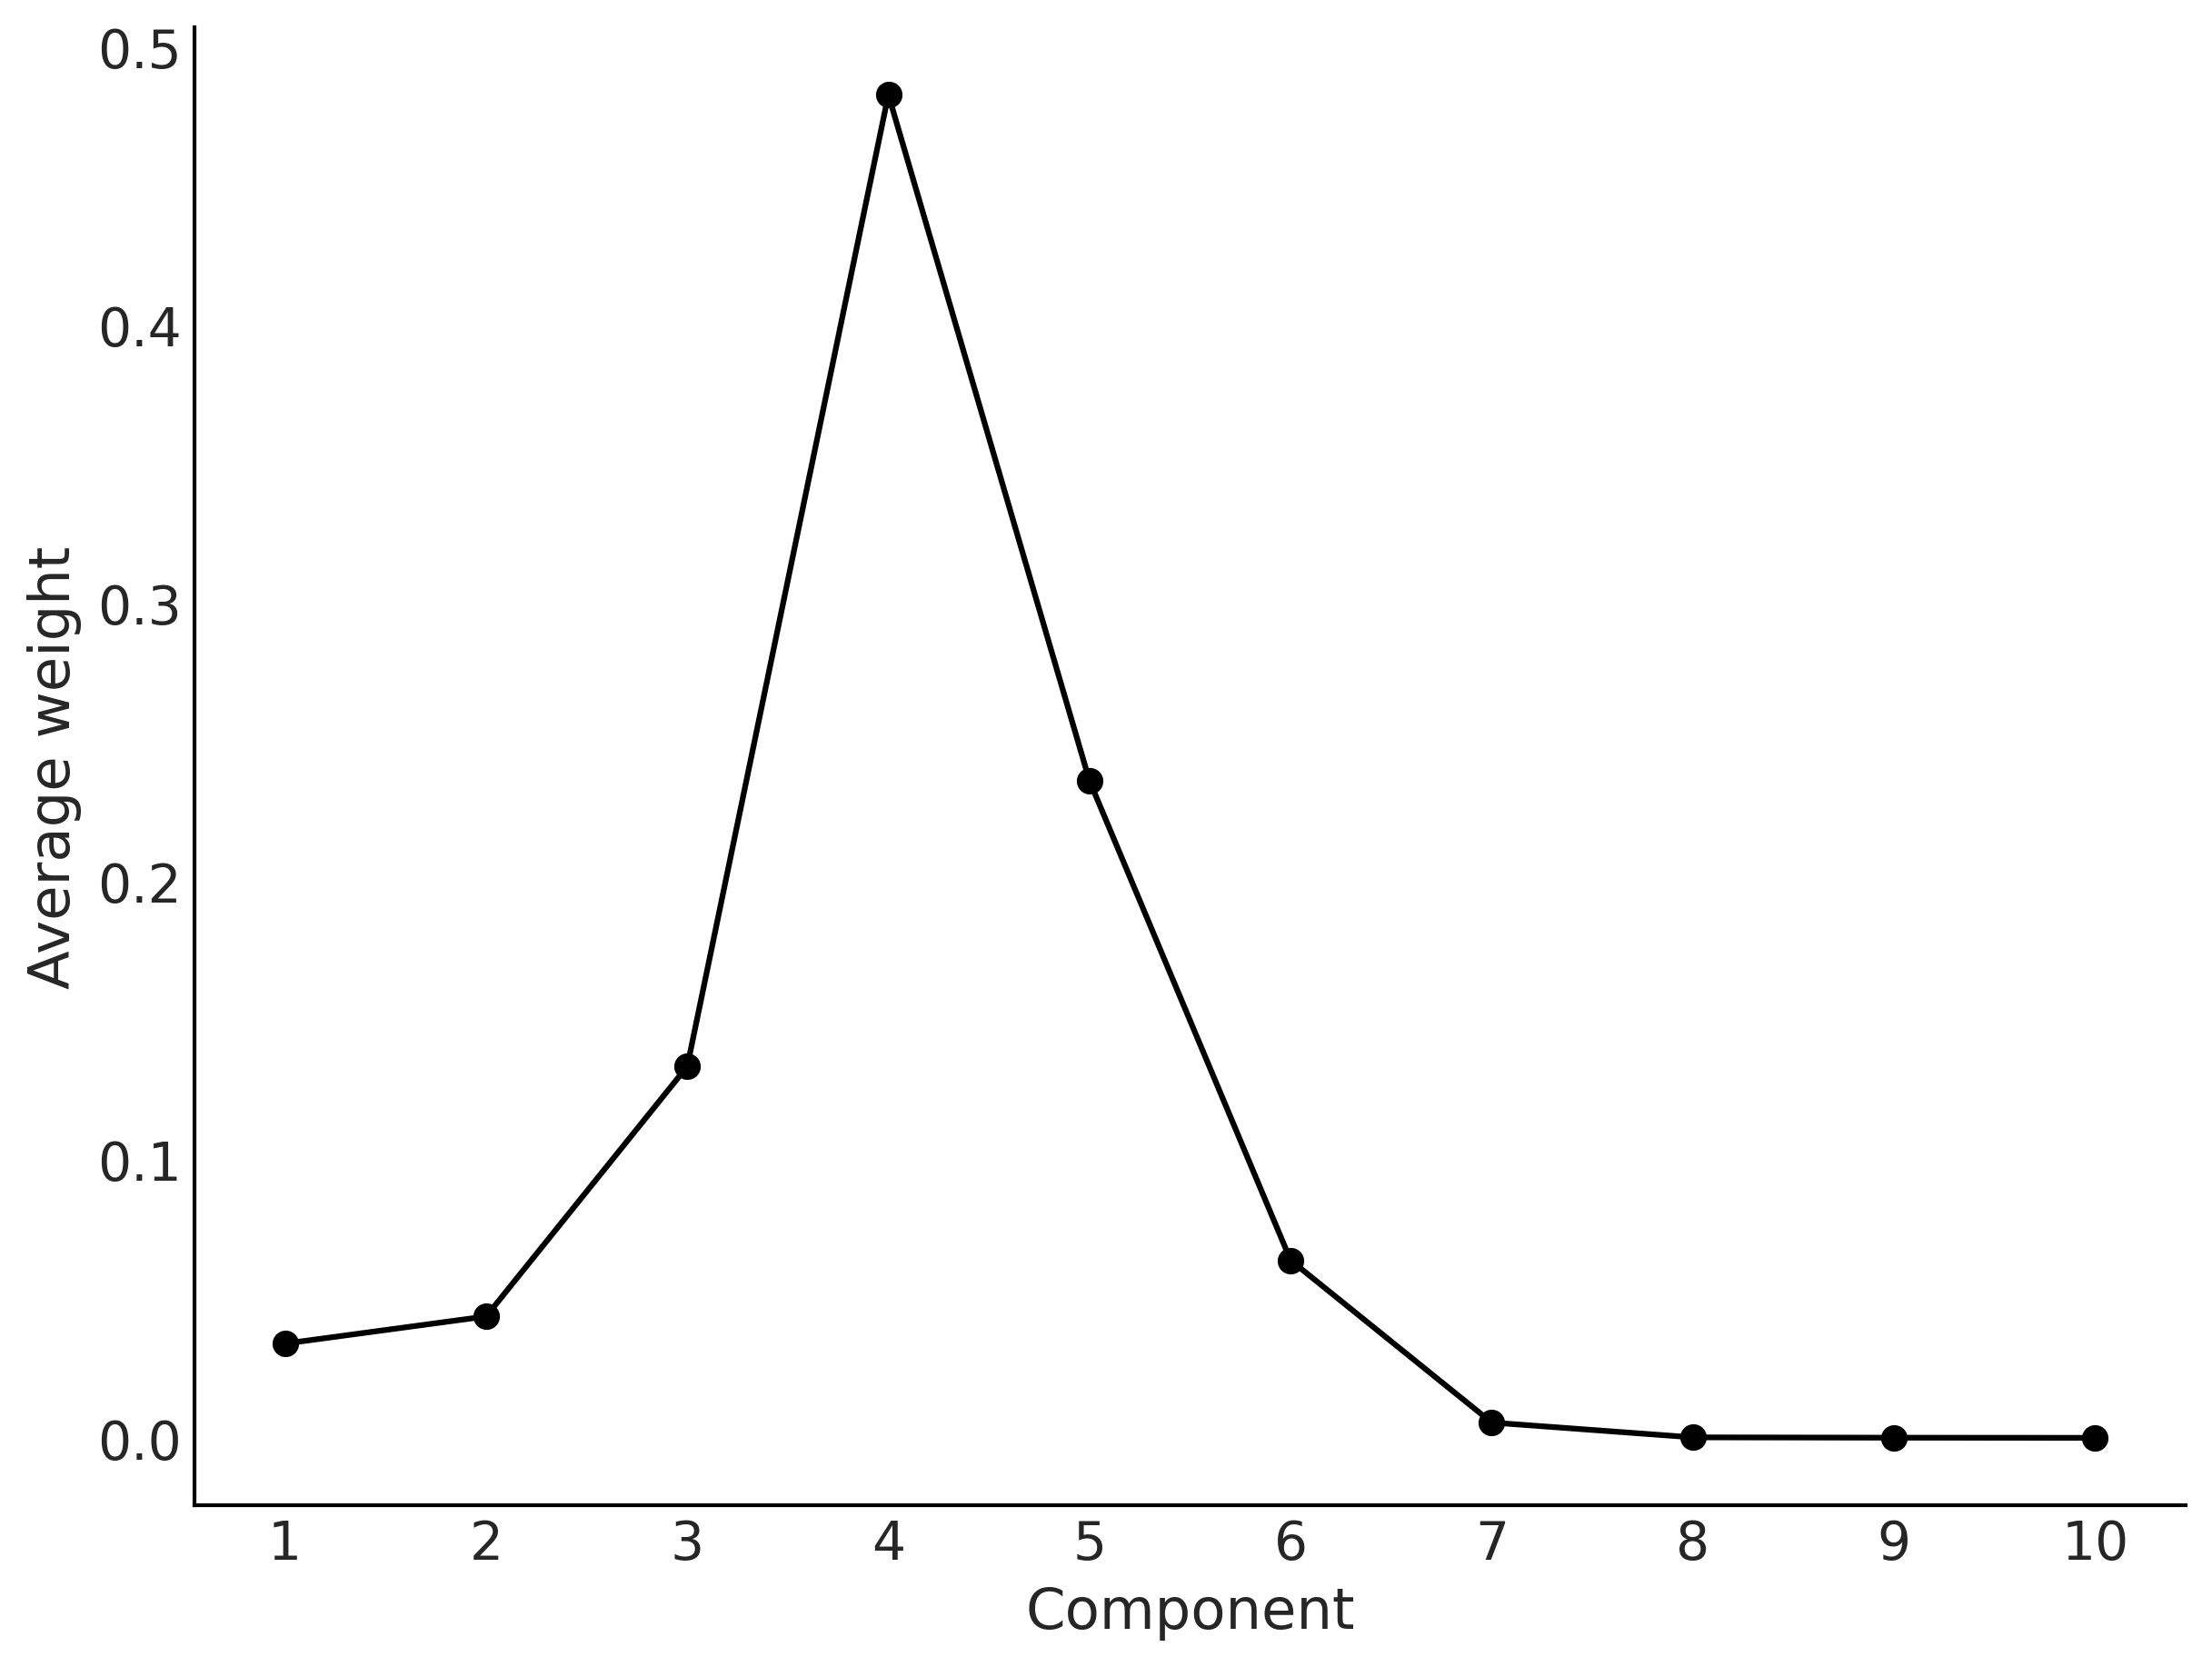

In [28]:
plt.figure(figsize=(8, 6))
plot_w = np.arange(K)
plt.plot(plot_w, idata.posterior['w'].mean(("chain", "draw")), 'o-')
plt.xticks(plot_w, plot_w+1)
plt.xlabel('Component')
plt.ylabel('Average weight')
plt.savefig('../fig/components_DP_mixture.png')

In [22]:
x_plot = np.linspace(cs.exp.min()-1, cs.exp.max()+1, 200)

posterior = idata.posterior.stack(samples=("chain", "draw"))

post_pdf_contribs = pz.Normal(posterior['means'].values[:, np.newaxis, :],
                              posterior['sd'].values[:, np.newaxis, :]).pdf(np.atleast_3d(x_plot))
post_pdfs = (posterior['w'].values[:, np.newaxis, :] * post_pdf_contribs).sum(axis=0)

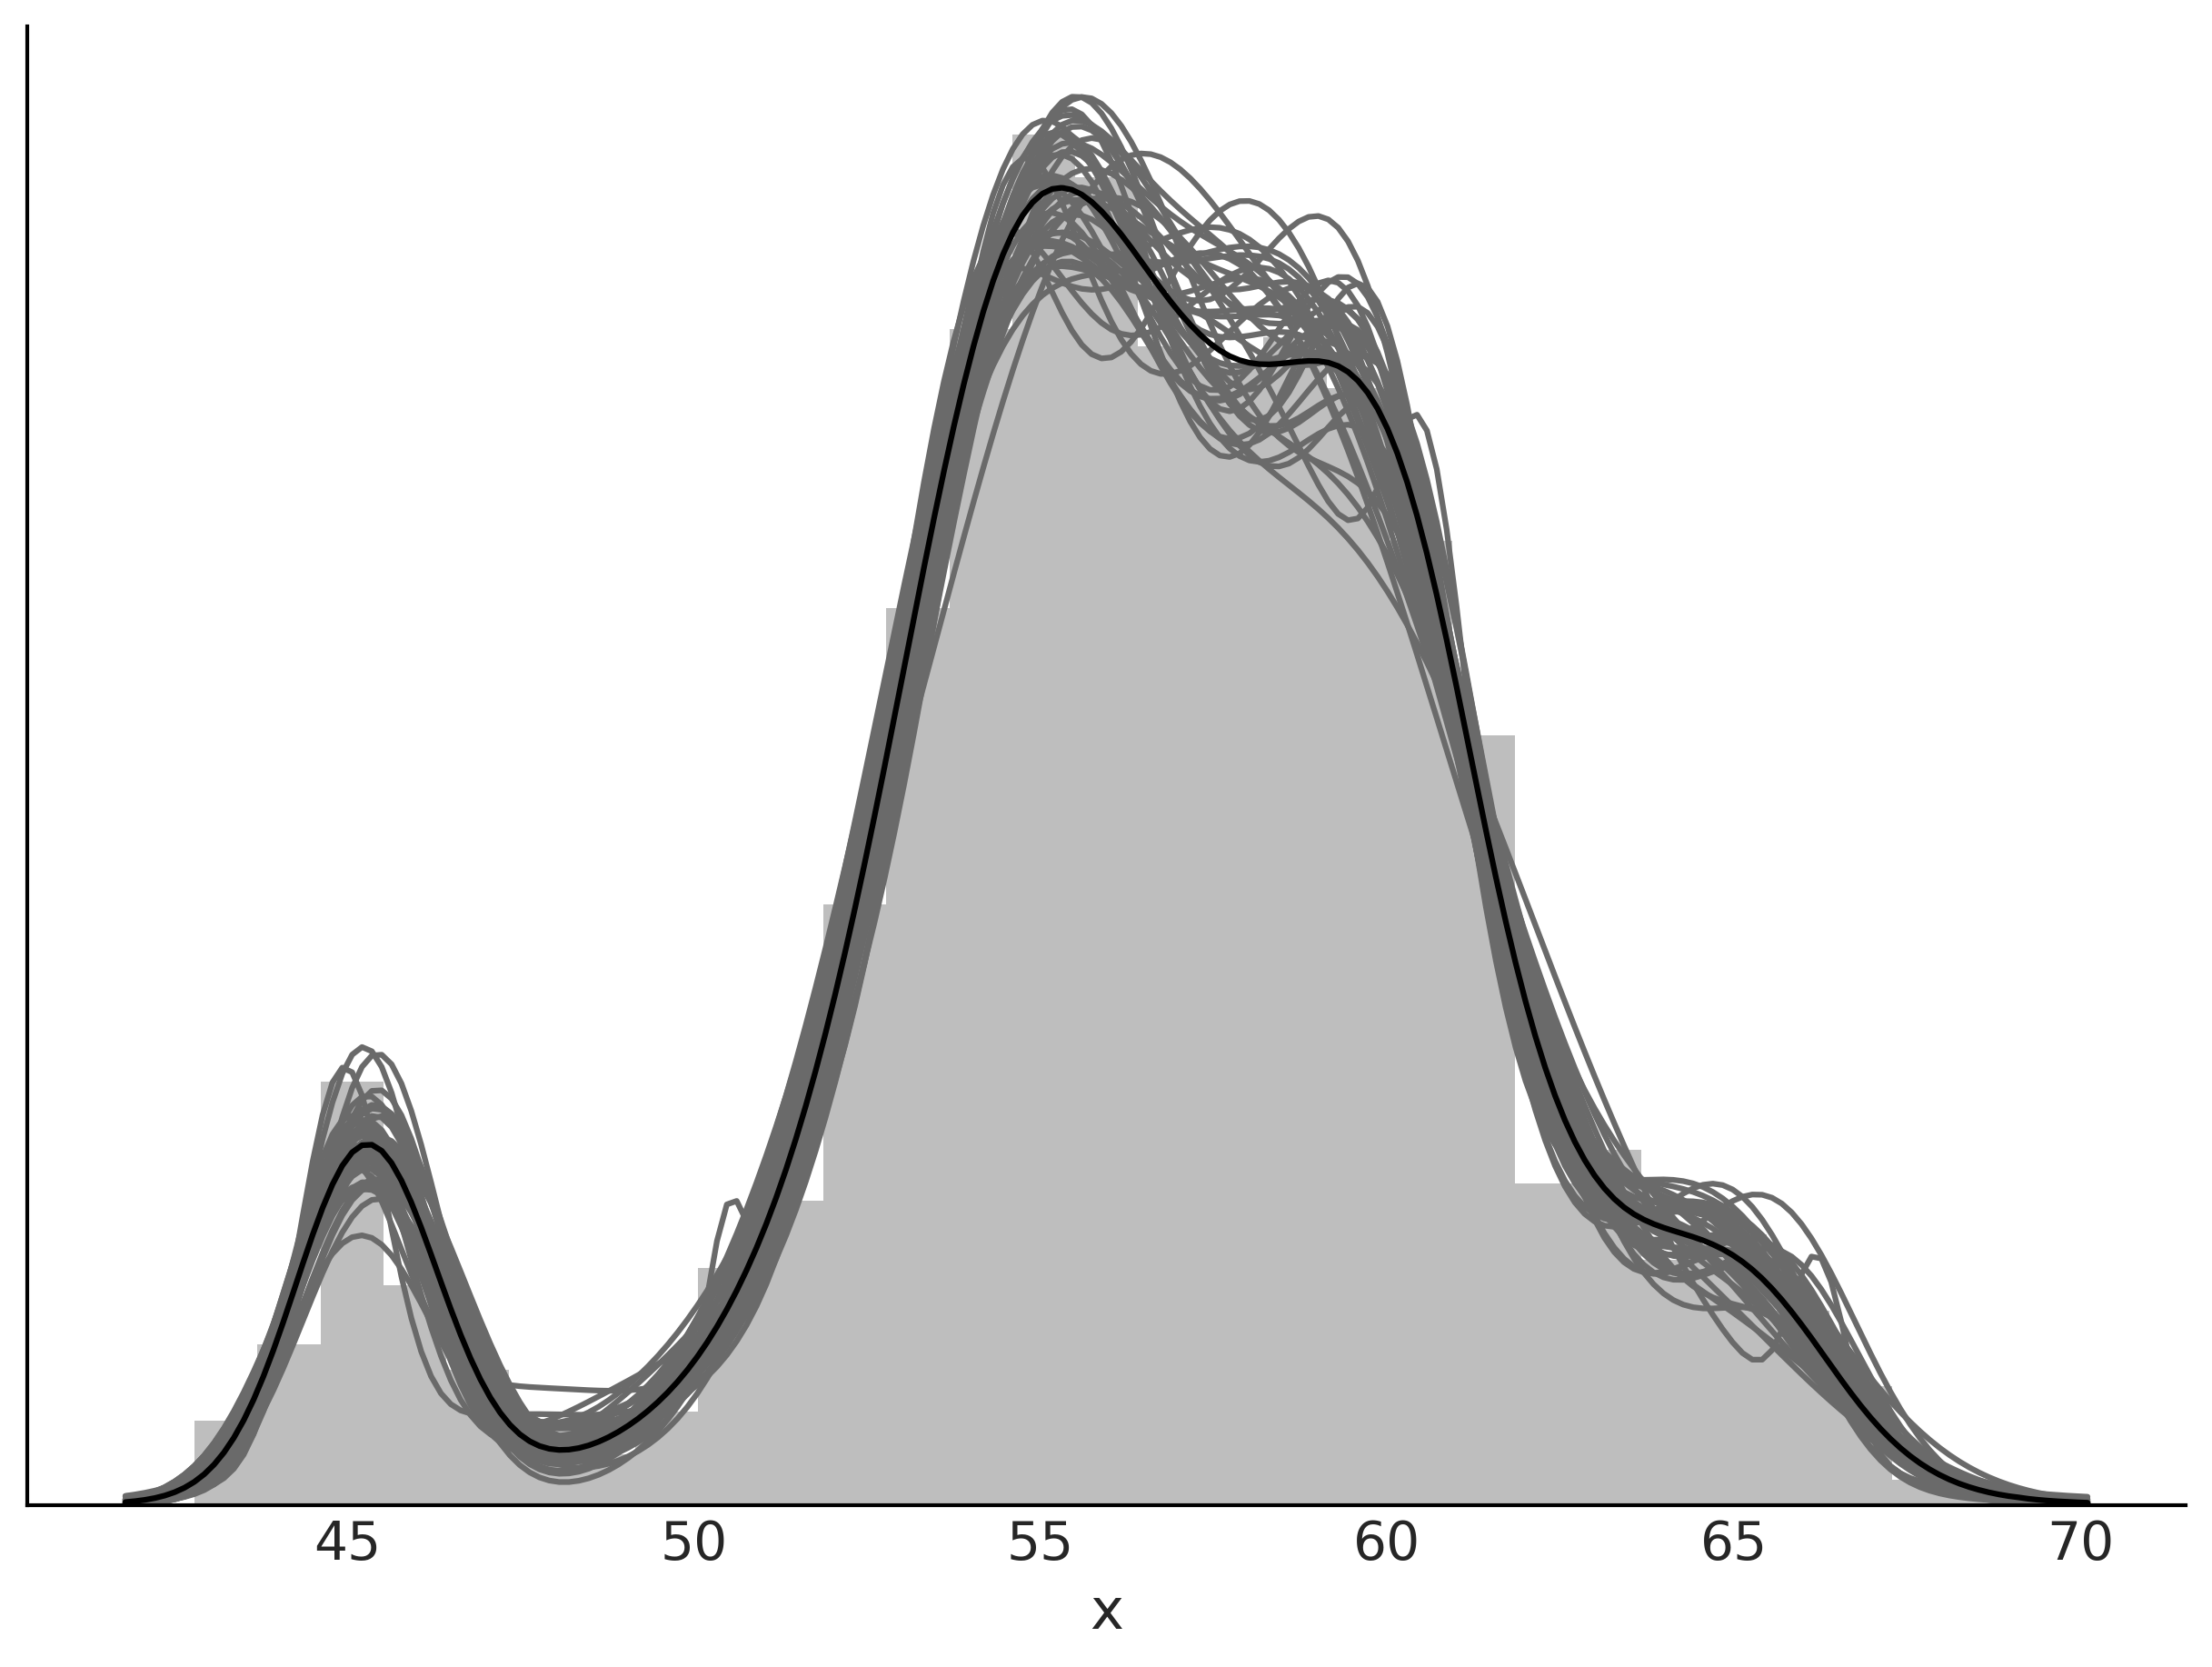

In [23]:
plt.figure(figsize=(8, 6))

plt.hist(cs_exp.values, bins="auto", density=True, color="C2")
plt.plot(x_plot, post_pdfs[:,::100], c='C1')
plt.plot(x_plot, post_pdfs.mean(axis=1), c='k')

plt.xlabel('x')
plt.yticks([])
plt.savefig('../fig/DP_mixture.png')